# 1. Importaciones y Configuración del Entorno

En esta sección instalamos y cargamos todas las librerías necesarias para el proyecto.  
Utilizamos `pip install` para instalar dependencias como `evaluate`, `transformers`, `datasets`, `seaborn`, `nltk`, `spacy`, entre otras, que son esenciales para tareas de procesamiento del lenguaje natural, minería de texto, visualización y modelado con Transformers.

También descargamos el modelo de lenguaje en inglés de spaCy (`en_core_web_sm`) para el preprocesamiento del texto.  
Luego se importan los módulos y funciones requeridas, incluyendo utilidades para la manipulación de datos (NumPy, pandas), visualización (matplotlib, seaborn, WordCloud), y varios módulos de NLP y Transformers.  

Finalmente, se define el dispositivo de cómputo a utilizar (GPU si está disponible, de lo contrario CPU).

In [2]:
# Instalar las dependencias necesarias (se ejecuta una sola vez)
!pip install -q evaluate transformers datasets seaborn nltk spacy torch chardet umap umap-learn wordcloud scikit-learn sentence_transformers transformers[torch] sentencepiece
!python3 -m spacy download en_core_web_sm

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Apps > Advanced app settings > App execution aliases.


In [3]:
# Importaciones
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import nltk, spacy
import torch, os, zipfile, chardet, umap
import pickle

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk import pos_tag
from evaluate import load
from torch.utils.data import Dataset
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import jensenshannon
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AlbertTokenizer,
    AlbertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
)

# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

c:\Users\juanm\Desktop\Workspace\ia\NLP-News-Classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando: cuda


# 2. Carga y Limpieza del Dataset

En esta sección se realiza la carga y limpieza de los datos de BBC.  
Primero, definimos una función `unzip_data` que descomprime los archivos ZIP (tanto para el conjunto de entrenamiento como para el de test).  
Luego, definimos la función `load_data` para recorrer las carpetas correspondientes a cada categoría (business, entertainment, politics, sports y tech).  
Esta función detecta automáticamente la codificación de cada archivo utilizando `chardet` y carga el texto, asignándole su categoría.  
Finalmente, se crean dos DataFrames (`df_train` y `df_test`) a partir de los datos descomprimidos.

In [4]:
# Función para descomprimir los archivos ZIP
def unzip_data(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)


# Descomprimir los datasets de entrenamiento y test
unzip_data("data/bbc-train.zip", "data")
unzip_data("data/bbc-test.zip", "data")

In [5]:
# Función para cargar los datos desde las carpetas correspondientes a cada categoría
def load_data(data_path):
    # Definimos las categorías que vamos a utilizar
    categories = ["business", "entertainment", "politics", "sports", "tech"]
    data = []

    # Función interna para detectar la codificación del archivo
    def detect_encoding(file_path):
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read())
        return result['encoding']

    # Recorrer cada categoría y cargar los archivos de texto
    for category in categories:
        folder_path = os.path.join(data_path, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            encoding = detect_encoding(file_path)
            with open(file_path, "r", encoding=encoding, errors="replace") as f:
                text = f.read()
                data.append((text, category))

    # Crear un DataFrame con el texto y la categoría correspondiente
    return pd.DataFrame(data, columns=["text", "category"])


# Cargar los conjuntos de entrenamiento y test
df_train = load_data("data/bbc-train/")
df_test = load_data("data/bbc-test/")

# 3. Preprocesamiento (Pipeline)

En esta sección se realiza el preprocesamiento de los textos.  
El proceso incluye:
1. Descargar recursos necesarios (NLTK, spaCy).
2. Cargar el modelo de spaCy para lematización.
3. Tokenización: convertir el texto a minúsculas y separar en tokens.
4. Estandarización: normalizar los tokens (por ejemplo, eliminar acentos).
5. Eliminación de stop-words: remover palabras muy comunes que aportan poco significado.
6. Stemming: reducir las palabras a su raíz.
7. Lematización: obtener la forma base de cada palabra.
8. Desambiguación: mapear etiquetas de POS a las etiquetas de WordNet y lematizar correctamente.
9. Construir la función final de preprocesamiento y aplicarla a nuestros DataFrames.
10. Generar n-gramas (bigrams y trigrams) para análisis posterior.

In [6]:
# Descargar recursos necesarios de NLTK
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Cargar el modelo de spaCy para lematización y configurar su longitud máxima
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 4e6

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
# Ejemplo de texto a procesar (tomado del primer registro del conjunto de entrenamiento)
example = df_train["text"].iloc[0]

## 1. Tokenización

Convertimos el texto a minúsculas y separamos en tokens utilizando NLTK.

In [8]:
tokens = word_tokenize(example.lower())  # Convertir a minúsculas y tokenizar
print("Primeros 9 tokens:", tokens[:9])

Primeros 9 tokens: ['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at']


## 2. Estandarización

Utilizamos spaCy para reconstruir el texto a partir de los tokens y normalizarlo, eliminando acentos y manteniendo solo tokens alfabéticos.

In [9]:
def standardize_tokens_spacy(tokens):
    text = " ".join(tokens)
    doc = nlp(text)

    standardized_tokens = [
        unicodedata.normalize("NFKD", token.text).encode("ASCII", "ignore").decode("utf-8")  # Eliminar acentos
        for token in doc
        if token.is_alpha
    ]

    return standardized_tokens

In [10]:
std_tokens = standardize_tokens_spacy(tokens)
print(std_tokens[:9])
print(f"Num tokens sin std: {len(tokens)}\nNum tokens con std: {len(std_tokens)}")

['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at']
Num tokens sin std: 490
Num tokens con std: 412


## 3. Eliminación de Stop-words

Removemos las stop-words usando la lista en inglés de NLTK.

In [11]:
stop_words = set(stopwords.words("english"))
stop_tokens = [token for token in std_tokens if token not in stop_words]
print(stop_tokens[:9])
print(f"Num tokens sin stop-words: {len(std_tokens)}\nNum tokens con stop-words: {len(stop_tokens)}")

['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'us']
Num tokens sin stop-words: 412
Num tokens con stop-words: 242


## 4. Stemming

Aplicamos el stemming para reducir los tokens a su raíz utilizando el PorterStemmer.

In [12]:
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(token) for token in stop_tokens]
stemmed_tokens[:9]

['ad',
 'sale',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterli',
 'profit',
 'us']

## 5. Lematización

Utilizamos spaCy para lematizar los tokens obtenidos tras el stemming.

In [13]:
lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(stemmed_tokens))]
lemmatized_tokens[:9]

['ad',
 'sale',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterli',
 'profit',
 'we']

## 6. Desambiguación

Definimos una función para mapear las etiquetas de POS de NLTK a las etiquetas de WordNet y aplicar una lematización más precisa.

In [14]:
def get_wordnet_pos(word):
    """Mapea las etiquetas de POS de NLTK a las de WordNet."""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
disambiguated_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in lemmatized_tokens]
disambiguated_tokens[:9]

['ad',
 'sale',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterli',
 'profit',
 'we']

## 7. Pipeline Final

Definimos una función `preprocess_text` que aplica todas las etapas de preprocesamiento sobre un texto:
1. Tokenización
2. Estandarización
3. Eliminación de stop-words
4. Stemming
5. Lematización
6. Desambiguación

Finalmente, aplicamos esta función a los DataFrames de entrenamiento y test.

In [15]:
def preprocess_text(text):
    # 1. Tokenización
    tokens = word_tokenize(text.lower())
    # 2. Estandarización
    tokens = standardize_tokens_spacy(tokens)
    # 3. Eliminación de stop-words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    # 4. Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    # 5. Lematización con spaCy
    tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    # 6. Desambiguación
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return tokens

In [16]:
# Aplicar el pipeline de preprocesamiento a los DataFrames
df_train["processed"] = df_train["text"].apply(preprocess_text)
df_test["processed"] = df_test["text"].apply(preprocess_text)

In [17]:
print(df_train["processed"].iloc[0][:9])
df_train.head()

['ad', 'sale', 'boost', 'time', 'warner', 'profit', 'quarterli', 'profit', 'we']


text  category  \
0  Ad sales boost Time Warner profit\n\nQuarterly...  business   
1  Dollar gains on Greenspan speech\n\nThe dollar...  business   
2  Yukos unit buyer faces loan claim\n\nThe owner...  business   
3  High fuel prices hit BA's profits\n\nBritish A...  business   
4  Pernod takeover talk lifts Domecq\n\nShares in...  business   

                                           processed  
0  [ad, sale, boost, time, warner, profit, quarte...  
1  [dollar, gain, greenspan, speech, dollar, hit,...  
2  [yuko, unit, buyer, face, loan, claim, owner, ...  
3  [high, fuel, price, hit, ba, profit, british, ...  
4  [pernod, takeov, talk, lift, domecq, share, uk...

In [18]:
print(df_test["processed"].iloc[0][:9])
df_test.head()

['u', 'trade', 'gap', 'hit', 'record', 'gap', 'we', 'export', 'import']


text  category  \
0  US trade gap hits record in 2004\n\nThe gap be...  business   
1  Yukos loses US bankruptcy battle\n\nA judge ha...  business   
2  Safety alert as GM recalls cars\n\nThe world's...  business   
3  Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...  business   
4  Strong demand triggers oil rally\n\nCrude oil ...  business   

                                           processed  
0  [u, trade, gap, hit, record, gap, we, export, ...  
1  [yuko, lose, we, bankruptci, battl, judg, dism...  
2  [safeti, alert, gm, recal, car, world, big, ca...  
3  [steel, firm, cut, job, mittal, steel, one, wo...  
4  [strong, demand, trigger, oil, ralli, crude, o...

## 8. Generación de N-gramas

Creamos bigramas y trigramas a partir de los tokens desambiguados, convirtiéndolos a cadenas para futuros análisis.

In [19]:
bigrams = list(ngrams(disambiguated_tokens, 2))
trigrams = list(ngrams(disambiguated_tokens, 3))

bigrams_str = [" ".join(grama) for grama in bigrams]
trigrams_str = [" ".join(grama) for grama in trigrams]

print(bigrams_str[:5])
print(trigrams_str[:5])

['ad sale', 'sale boost', 'boost time', 'time warner', 'warner profit']
['ad sale boost', 'sale boost time', 'boost time warner', 'time warner profit', 'warner profit quarterli']


# 4. Análisis de los Conjuntos de Datos

En esta sección se analiza el dataset mediante:
- Visualización de la distribución de clases (para entrenamiento y test).
- Estadísticas básicas sobre la longitud de los textos.
- Representación TF-IDF y extracción de palabras clave por categoría, con su visualización mediante WordCloud.
- Preparación de los datos supervisados, mapeando las etiquetas y dividiendo el conjunto de entrenamiento en entrenamiento y validación.
- Análisis con Word Embeddings: se obtienen vectores de palabras (Word2Vec usando spaCy) y se exploran palabras similares.
- Generación de Sentence Embeddings con un modelo preentrenado y reducción de dimensionalidad con UMAP para visualizar los documentos.
- Modelado de tópicos con LDA, mostrando las palabras más representativas de cada tema.

## Distribución de clases

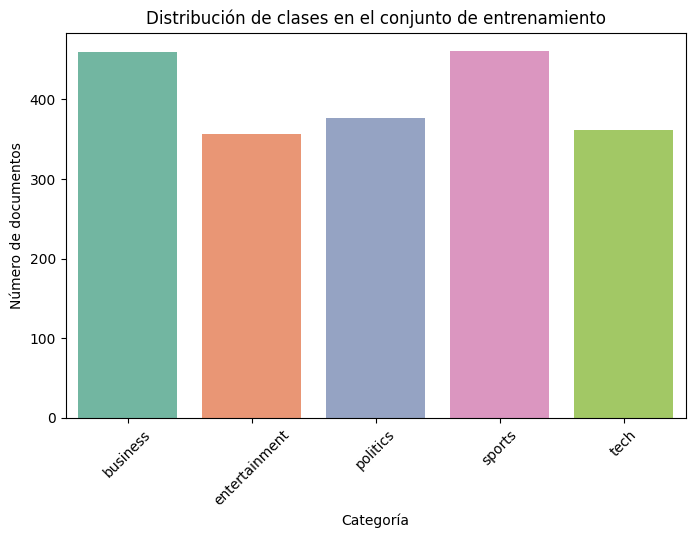

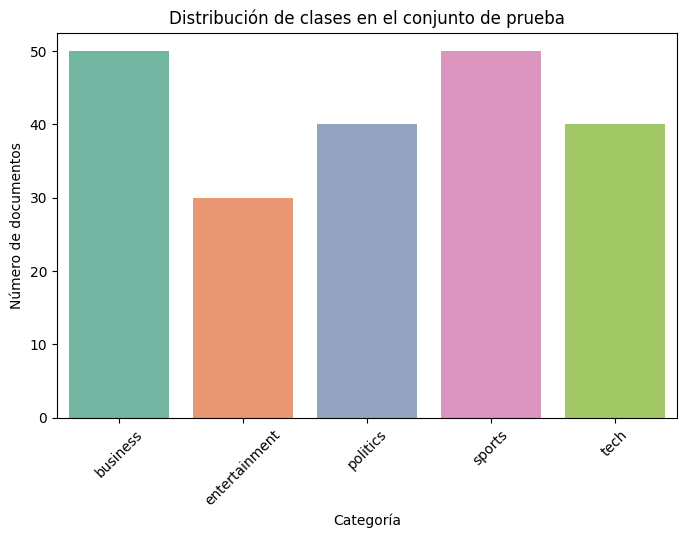

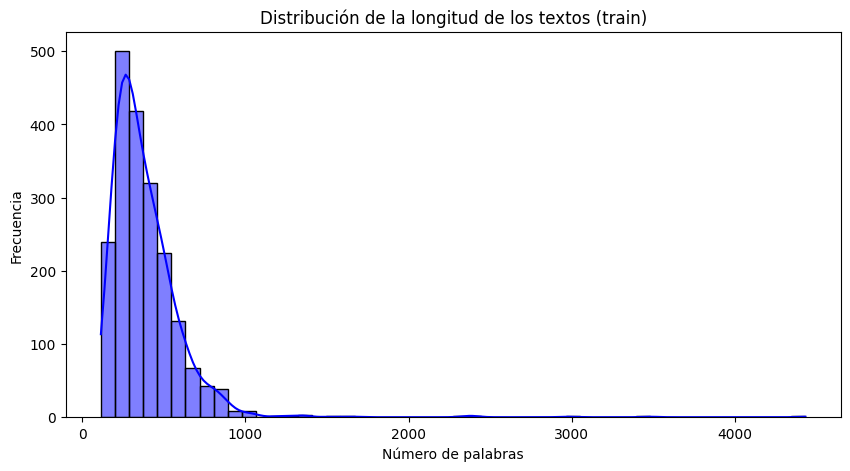

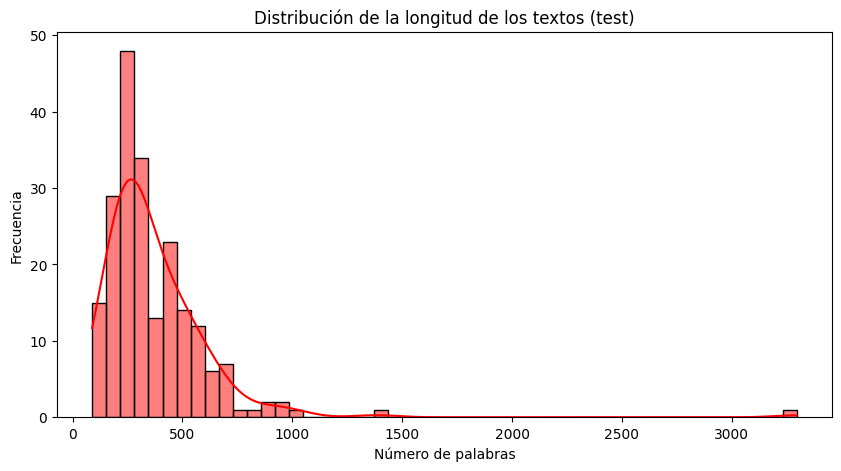

In [20]:
# Visualización de la distribución de clases en el conjunto de entrenamiento
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_train, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Visualización de la distribución de clases en el conjunto de prueba
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_test, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de prueba")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Estadísticas básicas: calcular la longitud de los textos (en número de palabras)
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
df_test["text_length"] = df_test["text"].apply(lambda x: len(x.split()))

# Histograma de la longitud de los textos en el conjunto de entrenamiento
plt.figure(figsize=(10, 5))
sns.histplot(df_train["text_length"], bins=50, kde=True, color="blue")
plt.title("Distribución de la longitud de los textos (train)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

# Histograma de la longitud de los textos en el conjunto de prueba
plt.figure(figsize=(10, 5))
sns.histplot(df_test["text_length"], bins=50, kde=True, color="red")
plt.title("Distribución de la longitud de los textos (test)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

## TF-IDF y Extracción de Palabras Clave

Primero convertimos los textos preprocesados (lista de tokens) en cadenas, para luego transformar el conjunto de datos con TF-IDF.  
A partir de la matriz TF-IDF, se calculan las palabras más representativas por categoría y se visualizan con WordCloud.

In [21]:
# Convertir los tokens preprocesados a texto
df_train["processed_text"] = df_train["processed"].apply(
    lambda tokens: " ".join(tokens)
)
df_test["processed_text"] = df_test["processed"].apply(lambda tokens: " ".join(tokens))

# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(df_train["processed_text"])
X_test_tfidf = vectorizer.transform(df_test["processed_text"])

# Extraer las palabras más relevantes por categoría
feature_names = vectorizer.get_feature_names_out()
category_keywords = {}

for category in df_train["category"].unique():
    idx = df_train[df_train["category"] == category].index
    mean_tfidf = X_train_tfidf[idx].mean(axis=0)
    # Obtener los índices de las 10 palabras con mayor TF-IDF
    sorted_indices = mean_tfidf.argsort()[0, -10:].tolist()[0]
    category_keywords[category] = [feature_names[i] for i in sorted_indices]

keywords = {f"{category}": [] for category, _ in category_keywords.items()}
for category, words in category_keywords.items():
    keywords[category] = words

# Mostrar palabras clave por categoría en formato de DataFrame
pd.DataFrame(keywords).T

0      1        2       3      4          5      6  \
business         rise  price  economi  growth   year     market   firm   
entertainment   oscar   year     band    good    say       show  music   
politics       minist  would    torus  govern  blair      parti  elect   
sports            cup   club     team   match    say     player    win   
tech           servic   user   comput   phone  peopl  technolog  mobil   

                     7      8     9  
business       compani   bank   say  
entertainment     star  award  film  
politics        labour    say    mr  
sports         england   play  game  
tech               say    use  game

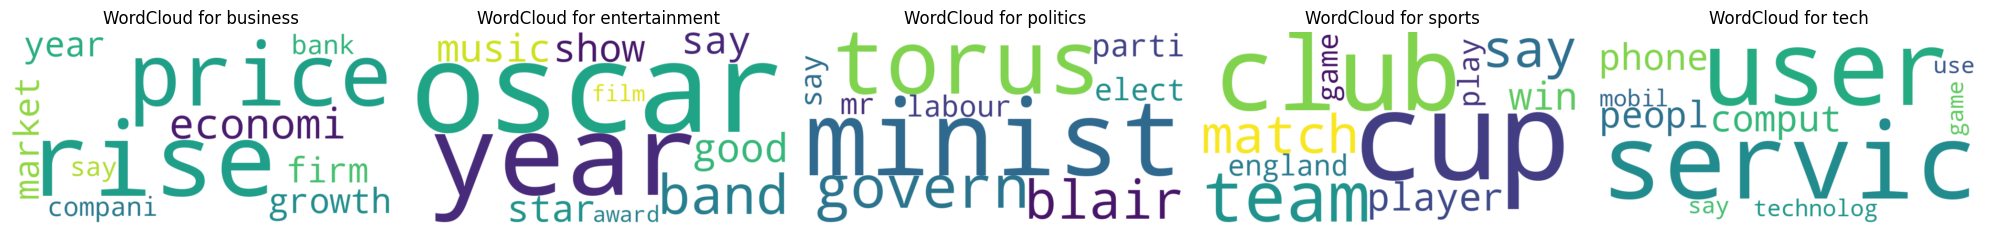

In [22]:
# Visualización con WordCloud: una gráfica para cada categoría
fig, axes = plt.subplots(1, len(category_keywords), figsize=(20, 6))
for idx, (category, words) in enumerate(category_keywords.items()):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        " ".join(words)
    )
    ax = axes[idx]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"WordCloud for {category}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Word Embeddings: Word2Vec con spaCy

Procesamos todos los textos del conjunto de entrenamiento para obtener vectores de palabras usando spaCy.  
Luego, calculamos la similitud coseno para encontrar las palabras más similares a un término objetivo (por ejemplo, "government").

In [27]:
# Procesar todos los textos del conjunto de entrenamiento para obtener vectores de palabras
sentences = df_train["processed"].apply(lambda x: " ".join(x)).tolist()
doc = nlp(" ".join(sentences))  # Procesar todo el texto con spaCy

# Obtener vectores para cada palabra (ignorando stopwords y puntuación)
word_vectors = {}
for token in doc:
    if not token.is_stop and not token.is_punct:
        word_vectors[token.text] = token.vector

# Lista de palabras objetivo para las cuales queremos encontrar las palabras más similares
target_words = ["government", "market", "film", "internet", "play"]

# Calcular y mostrar las 10 palabras más similares para cada palabra objetivo
for target_word in target_words:
    if target_word in word_vectors:
        target_vector = word_vectors[target_word]
        similarities = {}
        for word, vector in word_vectors.items():
            # Calcular similitud coseno
            similarity = (
                target_vector
                @ vector
                / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
            )
            similarities[word] = similarity
        # Obtener las 10 palabras con mayor similitud
        sorted_similarities = sorted(
            similarities.items(), key=lambda x: x[1], reverse=True
        )
        top_10_similar = sorted_similarities[:10]

        print(f"Palabras más similares a '{target_word}':")
        for word, sim in top_10_similar:
            print(f"{word}: {sim:.4f}")
        print("\n" + "-" * 50 + "\n")
    else:
        print(f"La palabra '{target_word}' no está en el vocabulario.\n")

Palabras más similares a 'government':
government: 1.0000
scamper: 0.7401
emili: 0.7194
person: 0.7129
region: 0.7092
struggler: 0.7059
actor: 0.6987
afflict: 0.6973
flatman: 0.6919
conductor: 0.6897

--------------------------------------------------

Palabras más similares a 'market':
market: 1.0000
censorship: 0.7659
livestock: 0.7631
artwork: 0.7613
system: 0.7575
partnership: 0.7566
exagger: 0.7501
camp: 0.7462
complexion: 0.7426
savant: 0.7404

--------------------------------------------------

Palabras más similares a 'film':
film: 1.0000
sledg: 0.7397
radioscap: 0.7354
economist: 0.7246
fuel: 0.7182
troncon: 0.7099
trilog: 0.7062
showtim: 0.7044
snicket: 0.7039
character: 0.7031

--------------------------------------------------

Palabras más similares a 'internet':
internet: 1.0000
rail: 0.8320
root: 0.8315
auto: 0.8115
termin: 0.8094
growth: 0.8088
easygroup: 0.8055
campaign: 0.8049
gospel: 0.8044
soap: 0.8028

--------------------------------------------------

Palabras má

## Sentence Embeddings y Reducción de Dimensionalidad con UMAP

Utilizamos el modelo `all-MiniLM-L6-v2` de SentenceTransformer para generar embeddings de las oraciones (documentos) y reducimos la dimensionalidad con UMAP para visualizar los documentos en un espacio 2D.

In [24]:
# Modelo de embeddings de oraciones
model = SentenceTransformer("all-MiniLM-L6-v2")

c:\Users\juanm\Desktop\Workspace\ia\NLP-News-Classifier\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


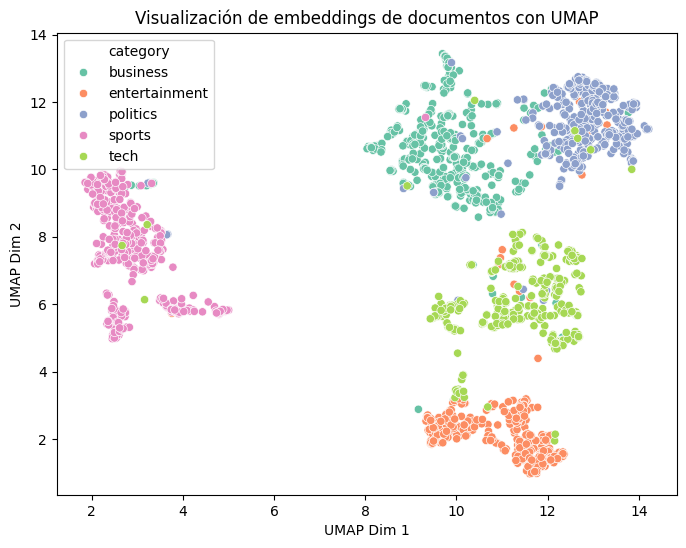

In [ ]:
# Generar embeddings
X_train_embeddings = model.encode(df_train["processed_text"])
X_test_embeddings = model.encode(df_test["processed_text"])

# Reducir la dimensionalidad con UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine")
X_reduced = reducer.fit_transform(X_train_embeddings)

# Visualización de los embeddings reducidos
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df_train["category"], palette="Set2"
)
plt.title("Visualización de embeddings de documentos con UMAP")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.show()

In [ ]:
# Crear y entrenar el modelo LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train_tfidf)

# Mostrar las palabras más representativas de cada tópico
for idx, topic in enumerate(lda.components_):
    # Se ordenan las palabras por importancia y se muestran las 10 más relevantes
    topic_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"Tema {idx + 1}: {topic_words}")

Tema business: ['slowdown', 'fall', 'price', 'export', 'economist', 'rise', 'dollar', 'economi', 'growth', 'rate']
Tema entertainment: ['viotti', 'cabir', 'blu', 'hendrix', 'euronext', 'tobacco', 'marsh', 'deutsch', 'boer', 'lse']
Tema politics: ['govern', 'also', 'make', 'new', 'peopl', 'would', 'film', 'year', 'mr', 'say']
Tema sports: ['ebber', 'beat', 'fiat', 'round', 'tenni', 'roddick', 'australian', 'gm', 'open', 'seed']
Tema tech: ['side', 'cup', 'good', 'team', 'club', 'player', 'play', 'win', 'game', 'england']


# 5. Modelado Supervisado con Transformers (BERT, ALBERT y RoBERTa)

En esta sección construimos y comparamos tres clasificadores de texto basados en Transformers: **BERT**, **ALBERT** y **RoBERTa**. El flujo general es:

1. Comprobar disponibilidad de GPU.  
2. Definir una clase `NewsDataset` que transforma textos tokenizados en tensores para PyTorch.  
3. Crear una función `compute_metrics` que calcula accuracy, F1, precision y recall usando la librería `evaluate`.  
4. Instanciar tokenizadores específicos de cada modelo y preparar datasets de entrenamiento, validación y test.  
5. Configurar `Trainer` y `TrainingArguments` idénticos para los tres modelos, entrenarlos, evaluarlos sobre el conjunto de test y guardar cada modelo+tokenizador.  
6. Recopilar resultados en un diccionario y generar dos visualizaciones:  
   - Una gráfica de líneas que compara el valor final de `eval_loss` de cada modelo.  
   - Un mapa de calor que muestra las métricas restantes (accuracy, F1, precision, recall) para cada modelo.  
7. Graficar la evolución del **training loss** durante el entrenamiento de cada modelo para visualizar su convergencia.

Con esta estructura podrás comparar fácilmente desempeño y comportamiento de los tres modelos en la tarea de clasificación de noticias.  

In [27]:
print(torch.cuda.is_available())

True


## Preparación de Datos Supervisados

En este paso asignamos valores numéricos a cada categoría y dividimos el conjunto de entrenamiento en entrenamiento (80%) y validación (20%) manteniendo la proporción de clases (estratificación). También preparamos las listas de textos y etiquetas para test.

In [ ]:
# Mapeo explícito de etiquetas a números
label_dict = {"business": 0, "entertainment": 1, "politics": 2, "sports": 3, "tech": 4}
df_train["label"] = df_train["category"].map(label_dict)
df_test["label"] = df_test["category"].map(label_dict)

# Dividir df_train en entrenamiento y validación (80/20) con estratificación

texts_train, texts_val, labels_train, labels_val = train_test_split(
    df_train["processed_text"].tolist(),
    df_train["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_train["label"],
)

# Preparar el conjunto de test
texts_test = df_test["processed_text"].tolist()
labels_test = df_test["label"].tolist()

print("Ejemplos de entrenamiento:", len(texts_train))
print("Ejemplos de validación:", len(texts_val))
print("Ejemplos de test:", len(texts_test))

## Definición del Dataset

La clase `NewsDataset` transforma listas de strings y etiquetas en batches de tensores (`input_ids`, `attention_mask`, `labels`) adecuados para el entrenamiento con Transformers.

In [28]:
# -----------------------------------------------------
# 1) Definición del Dataset y preparación de datos
# -----------------------------------------------------

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

## Métricas de Evaluación

La función `compute_metrics` utiliza la librería **evaluate** para calcular automáticamente las métricas clave:

- **Accuracy**  
- **F1-score (weighted)**  
- **Precision (weighted)**  
- **Recall (weighted)**  

Estas métricas se calculan sobre el conjunto de validación y prueba en cada época.

In [29]:
# -----------------------------------------------------
# 2) Definir la función de métricas (compute_metrics)
# -----------------------------------------------------

metric_accuracy = load("accuracy")
metric_f1 = load("f1")
metric_precision = load("precision")
metric_recall = load("recall")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "eval_accuracy": metric_accuracy.compute(
            predictions=predictions, references=labels
        )["accuracy"],
        "eval_f1": metric_f1.compute(
            predictions=predictions, references=labels, average="weighted"
        )["f1"],
        "eval_precision": metric_precision.compute(
            predictions=predictions, references=labels, average="weighted"
        )["precision"],
        "eval_recall": metric_recall.compute(
            predictions=predictions, references=labels, average="weighted"
        )["recall"],
    }

## Modelo BERT

- **Tokenizador:** `bert-base-uncased`  
- **Arquitectura:** `BertForSequenceClassification` con 5 clases  
- **Entrenamiento:** 20 épocas, batch size=8, evaluación por época  
- **Salida:** resultados finales en test y guardado del modelo/tokenizador

In [30]:
# -----------------------------------------------------
# 3) Preparar los datos (train, val, test)
# -----------------------------------------------------
# Suponiendo que tienes las variables: texts_train, labels_train, texts_val, labels_val, texts_test, labels_test

tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = NewsDataset(texts_train, labels_train, tokenizer_bert, max_len=512)
val_dataset = NewsDataset(texts_val, labels_val, tokenizer_bert, max_len=512)
test_dataset = NewsDataset(texts_test, labels_test, tokenizer_bert, max_len=512)

In [31]:
# -----------------------------------------------------
# 4) Entrenamiento y evaluación de BERT
# -----------------------------------------------------

model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=5
)
training_args_bert = TrainingArguments(
    output_dir="./results_BERT",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    logging_dir="./logs_BERT",
    logging_steps=50,
)
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print(">>> Entrenando modelo BERT...")
trainer_bert.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Entrenando modelo BERT...


TrainOutput(global_step=4040, training_loss=0.04611281693076236, metrics={'train_runtime': 1119.2813, 'train_samples_per_second': 28.804, 'train_steps_per_second': 3.609, 'total_flos': 8482928913039360.0, 'train_loss': 0.04611281693076236, 'epoch': 20.0})

In [32]:
print(">>> Evaluando modelo BERT en test...")
results_bert = trainer_bert.evaluate(test_dataset)
print("Resultados en test (BERT):", results_bert)

>>> Evaluando modelo BERT en test...


Resultados en test (BERT): {'eval_accuracy': 0.9857142857142858, 'eval_f1': 0.9857446519470349, 'eval_precision': 0.9859010270774976, 'eval_recall': 0.9857142857142858, 'eval_loss': 0.09344623982906342, 'eval_runtime': 2.4873, 'eval_samples_per_second': 84.427, 'eval_steps_per_second': 10.855, 'epoch': 20.0}


In [33]:
model_bert.save_pretrained("./models/modelBERT")
tokenizer_bert.save_pretrained("./models/modelBERT")

('./models/modelBERT\\tokenizer_config.json',
 './models/modelBERT\\special_tokens_map.json',
 './models/modelBERT\\vocab.txt',
 './models/modelBERT\\added_tokens.json')

## Modelo ALBERT

Misma configuración que BERT, pero usando el modelo más ligero **`albert-base-v2`**, para comparar precisión vs eficiencia.

In [34]:
# -----------------------------------------------------
# 5) Entrenamiento y evaluación de ALBERT
# -----------------------------------------------------

tokenizer_albert = AlbertTokenizer.from_pretrained("albert-base-v2")
train_dataset_albert = NewsDataset(
    texts_train, labels_train, tokenizer_albert, max_len=512
)
val_dataset_albert = NewsDataset(texts_val, labels_val, tokenizer_albert, max_len=512)
test_dataset_albert = NewsDataset(
    texts_test, labels_test, tokenizer_albert, max_len=512
)

model_albert = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2", num_labels=5
)
training_args_albert = TrainingArguments(
    output_dir="./results_ALBERT",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    logging_dir="./logs_ALBERT",
    logging_steps=50,
)
trainer_albert = Trainer(
    model=model_albert,
    args=training_args_albert,
    train_dataset=train_dataset_albert,
    eval_dataset=val_dataset_albert,
    compute_metrics=compute_metrics,
)

print(">>> Entrenando modelo ALBERT...")
trainer_albert.train()

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Entrenando modelo ALBERT...


c:\Users\juanm\Desktop\Workspace\ia\NLP-News-Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=4040, training_loss=0.20599191348831455, metrics={'train_runtime': 1101.1735, 'train_samples_per_second': 29.278, 'train_steps_per_second': 3.669, 'total_flos': 770703288975360.0, 'train_loss': 0.20599191348831455, 'epoch': 20.0})

In [35]:
print(">>> Evaluando modelo ALBERT en test...")
results_albert = trainer_albert.evaluate(test_dataset_albert)
print("Resultados en test (ALBERT):", results_albert)

>>> Evaluando modelo ALBERT en test...


Resultados en test (ALBERT): {'eval_accuracy': 0.9714285714285714, 'eval_f1': 0.9715289525684125, 'eval_precision': 0.9726582940868654, 'eval_recall': 0.9714285714285714, 'eval_loss': 0.21033655107021332, 'eval_runtime': 2.5415, 'eval_samples_per_second': 82.627, 'eval_steps_per_second': 10.623, 'epoch': 20.0}


In [36]:
model_albert.save_pretrained("./models/modelALBERT")
tokenizer_albert.save_pretrained("./models/modelALBERT")

('./models/modelALBERT\\tokenizer_config.json',
 './models/modelALBERT\\special_tokens_map.json',
 './models/modelALBERT\\spiece.model',
 './models/modelALBERT\\added_tokens.json')

## Modelo RoBERTa

Misma estructura de entrenamiento, pero con **`roberta-base`**, un modelo preentrenado en grandes colecciones de texto que suele mejorar ligeramente la precisión en tareas de clasificación.

In [37]:
# -----------------------------------------------------
# 6) Entrenamiento y evaluación de RoBERTa
# -----------------------------------------------------

tokenizer_roberta = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset_roberta = NewsDataset(
    texts_train, labels_train, tokenizer_roberta, max_len=512
)
val_dataset_roberta = NewsDataset(texts_val, labels_val, tokenizer_roberta, max_len=512)
test_dataset_roberta = NewsDataset(
    texts_test, labels_test, tokenizer_roberta, max_len=512
)

model_roberta = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=5
)
training_args_roberta = TrainingArguments(
    output_dir="./results_RoBERTa",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    logging_dir="./logs_RoBERTa",
    logging_steps=50,
)
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    compute_metrics=compute_metrics,
)

print(">>> Entrenando modelo RoBERTa...")
trainer_roberta.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> Entrenando modelo RoBERTa...


TrainOutput(global_step=4040, training_loss=0.07120645079521998, metrics={'train_runtime': 1068.174, 'train_samples_per_second': 30.182, 'train_steps_per_second': 3.782, 'total_flos': 8482928913039360.0, 'train_loss': 0.07120645079521998, 'epoch': 20.0})

In [38]:
print(">>> Evaluando modelo RoBERTa en test...")
results_roberta = trainer_roberta.evaluate(test_dataset_roberta)
print("Resultados en test (RoBERTa):", results_roberta)

>>> Evaluando modelo RoBERTa en test...


Resultados en test (RoBERTa): {'eval_accuracy': 0.9904761904761905, 'eval_f1': 0.9904761904761905, 'eval_precision': 0.9904761904761905, 'eval_recall': 0.9904761904761905, 'eval_loss': 0.06412617117166519, 'eval_runtime': 2.2421, 'eval_samples_per_second': 93.661, 'eval_steps_per_second': 12.042, 'epoch': 20.0}


In [39]:
model_roberta.save_pretrained("./models/modelRoBERTa")
tokenizer_roberta.save_pretrained("./models/modelRoBERTa")

('./models/modelRoBERTa\\tokenizer_config.json',
 './models/modelRoBERTa\\special_tokens_map.json',
 './models/modelRoBERTa\\vocab.json',
 './models/modelRoBERTa\\merges.txt',
 './models/modelRoBERTa\\added_tokens.json')

## Evaluación, Resultados y Gráfica Comparativa

Tras evaluar cada modelo en el conjunto de prueba, recopilamos sus métricas finales en un diccionario y generamos:

1. **Gráfica de líneas** que compara el valor final de `eval_loss`.  
2. **Heatmap** mostrando accuracy, F1, precision y recall de cada modelo.

Para cada modelo extraemos del historial de entrenamiento (`state.log_history`) los valores de `loss` por época y los graficamos en líneas superpuestas. Esto permite visualizar la convergencia de cada modelo y detectar posibles problemas de sobreajuste o subentrenamiento.



=== COMPARACIÓN FINAL DE MODELOS ===


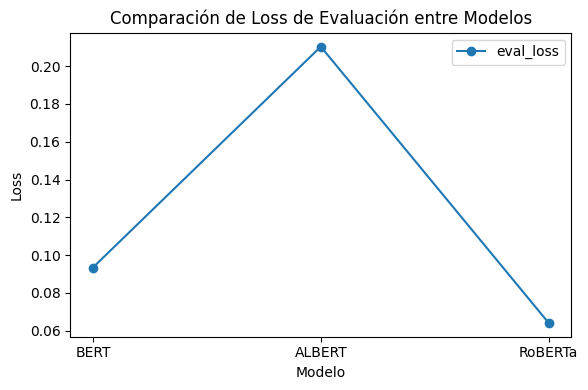

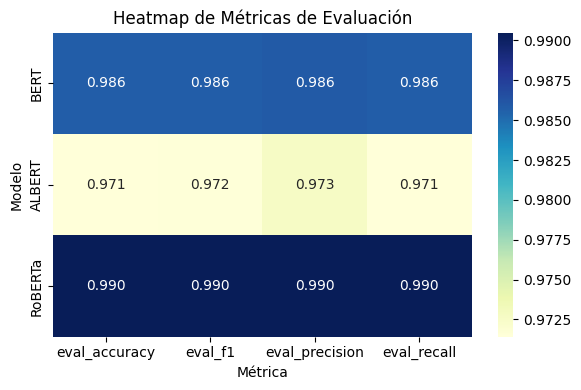



=== EVOLUCIÓN DEL TRAINING LOSS ===


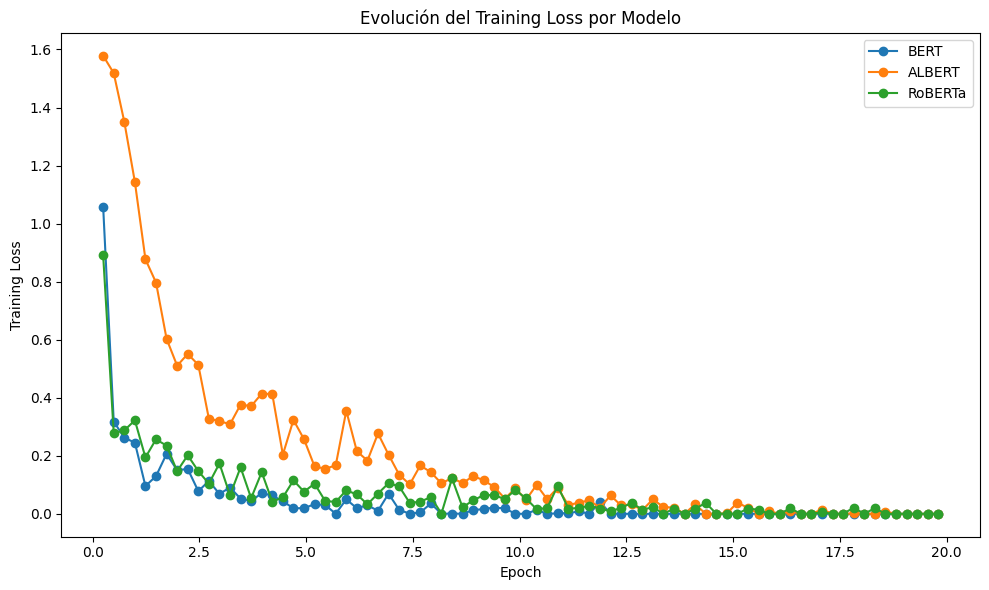

In [40]:
# -----------------------------------------------------
# 7) Recopilación de resultados y gráfica comparativa
# -----------------------------------------------------

# Diccionario con los resultados de evaluación para cada modelo
evaluation_results = {
    "BERT": results_bert,
    "ALBERT": results_albert,
    "RoBERTa": results_roberta,
}


def plot_model_results(evaluation_results):
    """
    Genera dos visualizaciones:
      1) Una gráfica de líneas para la métrica 'eval_loss'.
      2) Un heatmap para el resto de métricas.

    Se espera que evaluation_results tenga la siguiente estructura:
        {
            "BERT": {"eval_loss": ..., "eval_accuracy": ..., "eval_f1": ..., "eval_precision": ..., "eval_recall": ...},
            "ALBERT": {"eval_loss": ..., "eval_accuracy": ..., "eval_f1": ..., "eval_precision": ..., "eval_recall": ...},
            "RoBERTa": {"eval_loss": ..., "eval_accuracy": ..., "eval_f1": ..., "eval_precision": ..., "eval_recall": ...}
        }
    """
    # Convertir el diccionario en un DataFrame (filas: modelos, columnas: métricas)
    df = pd.DataFrame(evaluation_results).T

    # Definir las métricas de interés en un orden consistente
    metricas_de_interes = [
        "eval_loss",
        "eval_accuracy",
        "eval_f1",
        "eval_precision",
        "eval_recall",
    ]
    metricas_existentes = [m for m in metricas_de_interes if m in df.columns]
    df = df[metricas_existentes]

    # 1) Gráfica de líneas para 'eval_loss'
    if "eval_loss" in df.columns:
        plt.figure(figsize=(6, 4))
        # Aquí se asume que cada modelo aporta un único valor de loss;
        # si tienes un historial, este código conectará los valores por modelo.
        plt.plot(df.index, df["eval_loss"], marker="o", label="eval_loss")
        plt.title("Comparación de Loss de Evaluación entre Modelos")
        plt.xlabel("Modelo")
        plt.ylabel("Loss")
        plt.xticks(rotation=0)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 2) Heatmap para el resto de métricas (excluyendo eval_loss)
    df_heat = df.drop(columns=["eval_loss"], errors="ignore")
    if not df_heat.empty:
        plt.figure(figsize=(6, 4))
        sns.heatmap(df_heat, annot=True, cmap="YlGnBu", fmt=".3f")
        plt.title("Heatmap de Métricas de Evaluación")
        plt.ylabel("Modelo")
        plt.xlabel("Métrica")
        plt.tight_layout()
        plt.show()


# -----------------------------------------------------
# Función para graficar la evolución del training loss
# -----------------------------------------------------


def plot_training_loss(trainers_dict):
    """
    Genera una gráfica de líneas con la evolución del training loss para cada modelo.

    Se asume que cada trainer ha registrado en su 'state.log_history' entradas que incluyen 'loss' y 'epoch'.

    Parámetros:
      trainers_dict: dict
         Diccionario en el que las claves son los nombres de los modelos (ej. "BERT")
         y los valores son los objetos Trainer entrenados.
    """
    plt.figure(figsize=(10, 6))
    for model_name, trainer in trainers_dict.items():
        log_history = trainer.state.log_history
        epochs = []
        losses = []
        for log in log_history:
            if "loss" in log and "epoch" in log:
                epochs.append(log["epoch"])
                losses.append(log["loss"])
        if epochs:
            # Ordenar por epoch en caso de que no estén ordenados
            epochs, losses = zip(*sorted(zip(epochs, losses)))
            plt.plot(epochs, losses, marker="o", label=model_name)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Evolución del Training Loss por Modelo")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------
# Diccionarios de resultados y de trainers
# -----------------------------------------------------

# Diccionario con los resultados de evaluación (ya calculados)
# evaluation_results se creó más arriba

# Diccionario con los trainers entrenados para cada modelo
trainers_dict = {
    "BERT": trainer_bert,
    "ALBERT": trainer_albert,
    "RoBERTa": trainer_roberta,
}

# -----------------------------------------------------
# Llamadas a las funciones de visualización
# -----------------------------------------------------

print("\n\n=== COMPARACIÓN FINAL DE MODELOS ===")
plot_model_results(evaluation_results)

print("\n\n=== EVOLUCIÓN DEL TRAINING LOSS ===")
plot_training_loss(trainers_dict)

# 6. Búsqueda del Mejor Modelo No Supervisado (LDA)

En esta sección realizamos lo siguiente:

1. Definimos funciones auxiliares para:
   - Visualizar los tópicos extraídos (mostrar las palabras más representativas).
   - Generar nubes de palabras para cada tópico.
   - Visualizar la distribución de temas asignados y comparar con las categorías reales.
   - Comparar visualmente diversas métricas (Perplexity, JS Divergence, Purity Score y Topic Coherence) mediante un heatmap.

2. Definimos métricas de evaluación específicas:
   - Perplexity (negativo para que GridSearchCV maximice la métrica).
   - Purity Score (para ver qué tan bien se agrupan los documentos en tópicos).
   - Topic Coherence, calculada sin utilizar gensim (usando la métrica c_umass).

3. Se prepara la representación del texto (con Bag-of-Words o TF-IDF) usando diferentes rangos de n-gramas y valores máximos de features.

4. Se realiza una búsqueda en GridSearchCV para ajustar hiperparámetros de LDA (en este caso, `learning_decay`) y se evalúan los modelos en función de la pureza (usada como scoring).

5. Se guardan los resultados y se visualizan:
   - Para cada configuración se imprimen las métricas: perplexity, JS divergence, purity y topic coherence.
   - Se exportan los resultados a un archivo CSV.
   - Se generan gráficas comparativas (una gráfica de barras para cada grupo de n-gramas) y se visualizan los tópicos mediante nubes de palabras.

## Funciones auxiliares

In [41]:
# Visualización de los temas
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tema {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Nube de palabras
def plot_wordclouds(model, feature_names, num_topics):
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 5))
    for topic_idx, topic in enumerate(model.components_):
        word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-15 - 1:-1]}
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freq)
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis("off")
        axes[topic_idx].set_title(f"Tema {topic_idx+1}")
    plt.show()

def plot_topic_distribution(df, key):
    plt.figure(figsize=(8,5))
    sns.countplot(x=df["assigned_topic"], palette="Set2", hue=df["category"])
    plt.xlabel("Temas asignados por LDA")
    plt.ylabel("Número de documentos")
    plt.title(f"Distribución de documentos por tema - {key}")
    plt.show()

# Comparación entre temas asignados y categorías reales
def plot_category_vs_topic(df, key):
    plt.figure(figsize=(12,6))
    sns.countplot(x=df["assigned_topic"], hue=df["category"], palette="Set2")
    plt.xlabel("Temas asignados por LDA")
    plt.ylabel("Número de documentos")
    plt.title(f"Comparación entre temas asignados y categorías reales - {key}")
    plt.legend(title="Categoría real", bbox_to_anchor=(1,1))
    plt.show()


# Comparación visual de las métricas evaluadas
def plot_results(results):
    # Convertir los resultados en un DataFrame y trasponer
    df_results = pd.DataFrame(results).T

    # Extraer 'ngram_range' desde las claves del índice usando split
    df_results["ngram_range"] = df_results.index.map(lambda x: int(x.split("_")[2]))

    # Obtener valores únicos de ngram_range y ordenarlos
    ngram_ranges = sorted(df_results["ngram_range"].unique())

    # Iterar sobre cada ngram_range
    for ngram_range in ngram_ranges:
        # Filtrar los resultados para el ngram_range actual
        df_ngram = df_results[df_results["ngram_range"] == ngram_range]

        # Crear una figura con 1 fila y 3 columnas para las gráficas
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))

        # Gráfica de Perplexity en la primera columna
        if "perplexity" in df_ngram.columns:
            df_ngram[["perplexity"]].dropna().plot(kind="bar", legend=False, ax=axes[0])
            axes[0].set_title(f"Comparación de Perplexity (ngram_range: {ngram_range})")
            axes[0].set_ylabel("Perplexity")
            axes[0].set_xticks(range(len(df_ngram)))
            axes[0].set_xticklabels(df_ngram.index, rotation=30, ha="right")

        # Gráfica de otras métricas (excluyendo perplexity y topic_coherence) en la segunda columna
        other_metrics = df_ngram.drop(
            columns=["perplexity", "topic_coherence", "ngram_range"], errors="ignore"
        )
        if not other_metrics.empty:
            other_metrics.plot(kind="bar", ax=axes[1])
            axes[1].set_title(
                f"Comparación de otras métricas (ngram_range: {ngram_range})"
            )
            axes[1].set_xticks(range(len(df_ngram)))
            axes[1].set_xticklabels(df_ngram.index, rotation=30, ha="right")

        # Gráfica de Topic Coherence en la tercera columna
        if "topic_coherence" in df_ngram.columns:
            df_ngram[["topic_coherence"]].dropna().plot(
                kind="bar", legend=False, ax=axes[2]
            )
            axes[2].set_title(
                f"Comparación de Coherencia de Tópicos (ngram_range: {ngram_range})"
            )
            axes[2].set_ylabel("Topic Coherence")
            axes[2].set_xticks(range(len(df_ngram)))
            axes[2].set_xticklabels(df_ngram.index, rotation=30, ha="right")

        # Ajustar el diseño
        plt.tight_layout()
        plt.show()

## Métricas a evaluar

In [42]:
# Función para evaluar Perplexity
def lda_perplexity_score(model, X):
    return -model.perplexity(X)  # Negativo porque GridSearchCV maximiza la métrica

# Función para calcular Purity Score
def purity_score(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

# Métrica personalizada para GridSearchCV
def lda_purity_scorer(estimator, X, y_true):
    assigned_topics = np.argmax(estimator.transform(X), axis=1)
    return purity_score(y_true, assigned_topics)

def compute_topic_coherence_no_gensim(lda_model, vectorizer, texts, top_n=15):
    """
    Calcula la coherencia de tópicos usando la métrica c_umass sin gensim.

    Parámetros:
      - lda_model: Modelo LDA entrenado (sklearn).
      - vectorizer: El vectorizador usado (CountVectorizer o TfidfVectorizer).
      - texts: Lista de documentos tokenizados (lista de listas de tokens).
      - top_n: Número de palabras a considerar por tópico.

    Retorna:
      - coherence: Valor promedio de coherencia c_umass para todos los tópicos.
    """
    # Extraer nombres de características y definir los tópicos
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[: -top_n - 1 : -1]]
        topics.append(topic_words)

    # Crear contadores de frecuencia: para cada palabra, cuántos documentos la contienen
    # y para cada par de palabras, cuántos documentos las contienen conjuntamente.
    doc_freq = defaultdict(int)
    pair_freq = defaultdict(int)

    # Convertir cada documento a un conjunto para evitar contar repeticiones
    docs = [set(doc) for doc in texts]

    for doc in docs:
        for word in doc:
            doc_freq[word] += 1
        doc_list = list(doc)
        for i in range(len(doc_list)):
            for j in range(i + 1, len(doc_list)):
                # Ordenamos la pareja para tener una clave única
                key = tuple(sorted([doc_list[i], doc_list[j]]))
                pair_freq[key] += 1

    # Calcular c_umass para cada tópico
    topic_coherences = []
    for topic_words in topics:
        score = 0.0
        pair_count = 0
        # Se consideran pares (w_i, w_j) con i > j
        for i in range(1, len(topic_words)):
            for j in range(0, i):
                w_i = topic_words[i]
                w_j = topic_words[j]
                key = tuple(sorted([w_i, w_j]))
                # Usamos la frecuencia de w_i como denominador (podrías usar w_j, según la definición)
                D_wi = doc_freq[w_i]
                D_wi_wj = pair_freq.get(key, 0)
                if D_wi > 0:
                    score += np.log((D_wi_wj + 1) / D_wi)
                    pair_count += 1
        if pair_count > 0:
            topic_coherences.append(score / pair_count)

    if topic_coherences:
        return np.mean(topic_coherences)
    else:
        return 0.0

perplexity_scorer = make_scorer(lda_perplexity_score, greater_is_better=True)

## Representación del Texto y Búsqueda de Modelos LDA

Se define una función `represent_text` para convertir los tokens preprocesados en una representación numérica mediante Bag-of-Words (bow) o TF-IDF.  
Luego, se utiliza GridSearchCV para ajustar el hiperparámetro `learning_decay` de LDA utilizando diferentes configuraciones de n-gramas y número máximo de features.  
Cada configuración se evalúa usando la métrica de pureza y se calculan además las métricas de Perplexity, JS Divergence y Topic Coherence.

In [43]:
# Función para representar texto con diferentes n-gramas
def represent_text(df, method, ngram_range=(1,1), max_features=1000):
    processed_str = df["processed"].apply(lambda x: " ".join(x))

    if method == "bow":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    else:
        raise ValueError("Método no válido")

    return vectorizer, vectorizer.fit_transform(processed_str)

In [44]:
# Evaluación en df_test con GridSearchCV usando n-gramas
representations = ["bow", "tfidf"]
n_gram_ranges = [(1,1), (1,2), (1,3)]
max_features = [500, 1000, 1500, 2000]

param_grid = {"learning_decay": [0.3, 0.5, 0.7, 0.9]}
results = {}
models = {}

# --- En el bucle de GridSearch, reemplazamos la llamada a compute_topic_coherence por la versión sin gensim

for rep in representations:
    for max_feature in max_features:
        for ngram_range in n_gram_ranges:
            vectorizer, X_train = represent_text(
                df_train, method=rep, ngram_range=ngram_range, max_features=max_feature
            )
            X_test = vectorizer.transform(df_test["processed_text"])

            grid_search = GridSearchCV(
                LatentDirichletAllocation(n_components=5, random_state=42),
                param_grid,
                cv=5,
                n_jobs=-1,
                verbose=1,
                scoring=lda_purity_scorer,
            )
            grid_search.fit(X_train, df_train["category"])
            best_lda = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_

            print(
                f"Mejores hiperparámetros para {rep} con n-gramas {ngram_range}: {best_params}"
            )

            perplexity = best_lda.perplexity(X_test)

            # Diversidad de temas
            assigned_topics = np.argmax(best_lda.transform(X_test), axis=1)

            # Divergencia de Jensen-Shannon
            topic_distributions = best_lda.transform(X_test)
            js_divergence = np.mean(
                [
                    jensenshannon(topic_distributions[i], topic_distributions[j])
                    for i in range(len(topic_distributions))
                    for j in range(i + 1, len(topic_distributions))
                ]
            )

            # Purity Score
            purity = purity_score(df_test["category"], assigned_topics)

            # Calcular Topic Coherence sin gensim, usando los textos tokenizados del train
            # Se asume que df_train["processed"] es una columna de listas de tokens.
            topic_coherence = compute_topic_coherence_no_gensim(
                best_lda, vectorizer, df_train["processed"].tolist()
            )

            # Almacenar todos los resultados en el diccionario results
            key = f"{rep}_ngram_{ngram_range[1]}_maxfeature_{max_feature}"
            results[key] = {
                "perplexity": perplexity,
                "js_divergence": js_divergence,
                "purity_score": purity,
                "topic_coherence": topic_coherence,
            }

            models[key] = {"model": best_lda, "params": best_params, "score": purity}

            print(
                f"\nRepresentación: {rep} con n-gramas {ngram_range} - Perplexity: {perplexity},"
            )
            print(
                f"JS Divergence: {js_divergence},"
            )
            print(f"Purity Score: {purity}, Topic Coherence: {topic_coherence}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 1): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 1) - Perplexity: 373.81716985316035,
JS Divergence: 0.6325553945306714,
Purity Score: 0.9142857142857143, Topic Coherence: -0.9851195845654319
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 2): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 2) - Perplexity: 385.45820922553014,
JS Divergence: 0.6124360729805076,
Purity Score: 0.6952380952380952, Topic Coherence: -0.857909414241503
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 3): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 3) - Perplexity: 385.45820922553014,
JS Divergence: 0.6124360729805076,
Purity Score: 0.6952380952380952, Topic Coherence: -0.857909414241503
Fitting 5 folds for each of 4 candidates, tot

## Evaluación y Visualización de Resultados

Se guardan los resultados obtenidos en un archivo CSV y se generan visualizaciones:
- Un heatmap y gráficos de barras para comparar las métricas de cada configuración.
- Gráficas para visualizar la distribución de temas asignados y la relación con las categorías reales.
- Se muestran nubes de palabras para cada tópico.
Finalmente, se guardan los modelos LDA en un archivo pickle.

In [45]:
df_results = pd.DataFrame(results)
df_results.to_csv('csv_files/results/results_lda.csv')
df_results

bow_ngram_1_maxfeature_500  bow_ngram_2_maxfeature_500  \
perplexity                       373.817170                  385.458209   
js_divergence                      0.632555                    0.612436   
purity_score                       0.914286                    0.695238   
topic_coherence                   -0.985120                   -0.857909   

                 bow_ngram_3_maxfeature_500  bow_ngram_1_maxfeature_1000  \
perplexity                       385.458209                   720.807104   
js_divergence                      0.612436                     0.634811   
purity_score                       0.695238                     0.933333   
topic_coherence                   -0.857909                    -0.934714   

                 bow_ngram_2_maxfeature_1000  bow_ngram_3_maxfeature_1000  \
perplexity                        736.760491                   718.660899   
js_divergence                       0.613264                     0.636272   
purity_score                        0.828571                     0.928571   
topic_coherence                    -0.935779                    -0.947475   

                 bow_ngram_1_maxfeature_1500  bow_ngram_2_maxfeature_1500  \
perplexity                       1101.186858                  1051.654354   
js_divergence                       0.617138                     0.638180   
purity_score                        0.723810                     0.952381   
topic_coherence                    -0.891266                    -0.944643   

                 bow_ngram_3_maxfeature_1500  bow_ngram_1_maxfeature_2000  \
perplexity                       1060.973150                  1457.881901   
js_divergence                       0.634617                     0.593055   
purity_score                        0.919048                     0.571429   
topic_coherence                    -0.922710                    -0.933867   

                 ...  tfidf_ngram_3_maxfeature_500  \
perplexity       ...                   4833.775064   
js_divergence    ...                      0.504167   
purity_score     ...                      0.757143   
topic_coherence  ...                     -1.413919   

                 tfidf_ngram_1_maxfeature_1000  tfidf_ngram_2_maxfeature_1000  \
perplexity                        23287.162635                   19766.898681   
js_divergence                         0.514579                       0.522709   
purity_score                          0.719048                       0.819048   
topic_coherence                      -1.271371                      -1.376927   

                 tfidf_ngram_3_maxfeature_1000  tfidf_ngram_1_maxfeature_1500  \
perplexity                        18810.024028                   37753.252760   
js_divergence                         0.501595                       0.484896   
purity_score                          0.714286                       0.604762   
topic_coherence                      -1.548545                      -1.710805   

                 tfidf_ngram_2_maxfeature_1500  tfidf_ngram_3_maxfeature_1500  \
perplexity                        34461.164742                   74520.942629   
js_divergence                         0.433333                       0.535477   
purity_score                          0.633333                       0.776190   
topic_coherence                      -1.590457                      -1.140235   

                 tfidf_ngram_1_maxfeature_2000  tfidf_ngram_2_maxfeature_2000  \
perplexity                        54706.176562                   68711.581801   
js_divergence                         0.396502                       0.449087   
purity_score                          0.476190                       0.566667   
topic_coherence                      -1.606989                      -1.694091   

                 tfidf_ngram_3_maxfeature_2000  
perplexity                        63625.416081  
js_divergence                         0.452124  
purity_score                          0.633333  
topic_coher

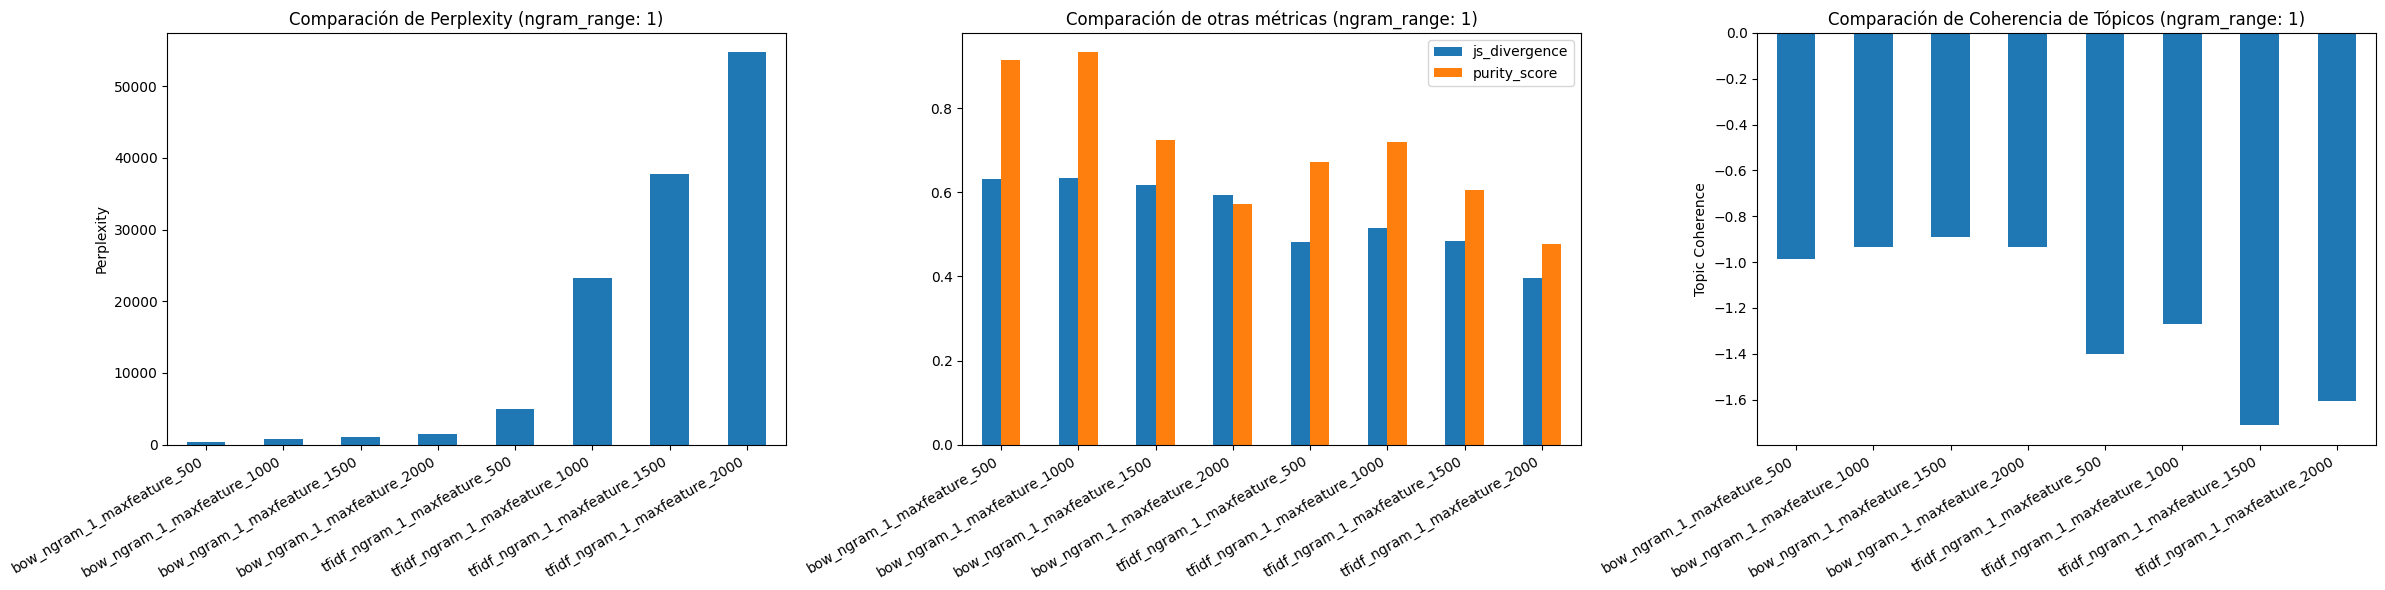

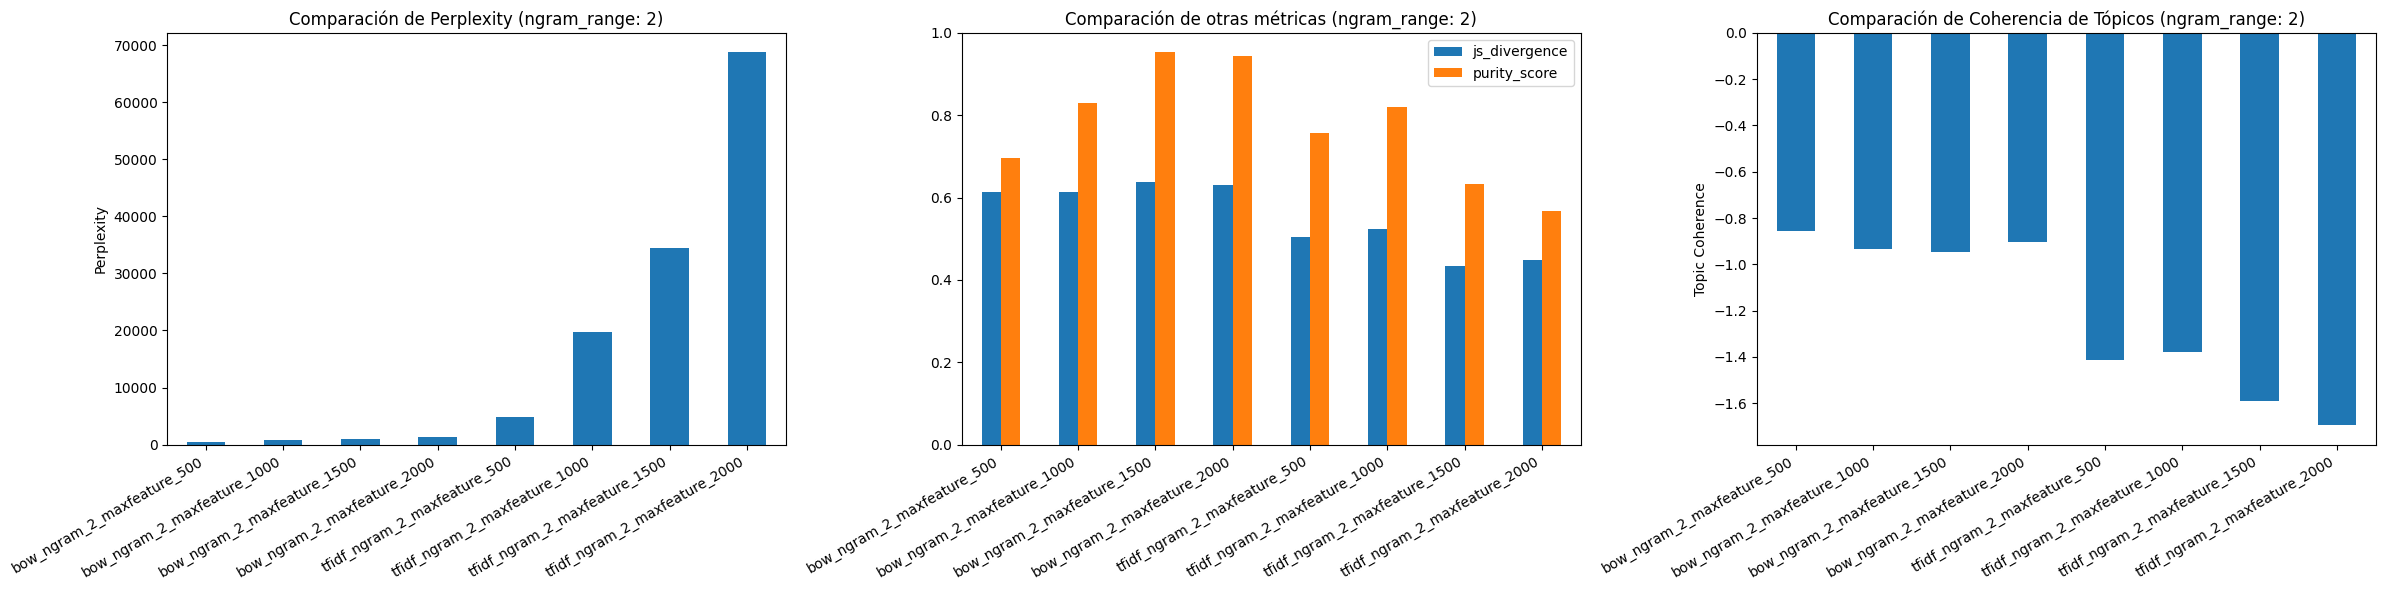

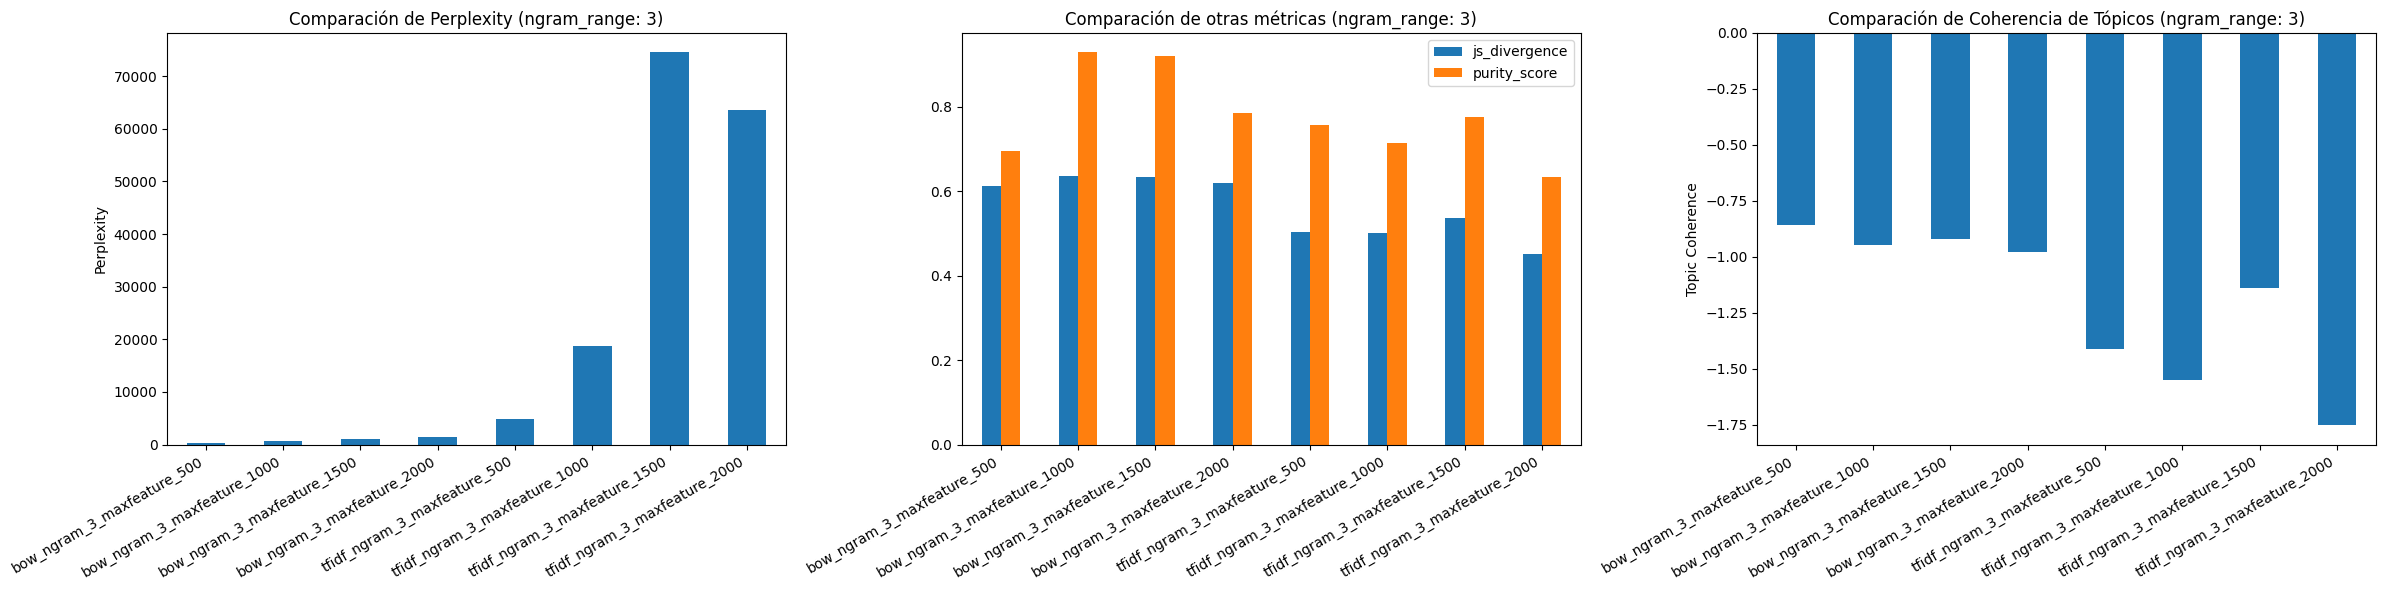

In [46]:
plot_results(results)



Graphics bow_ngram_1_maxfeature_500




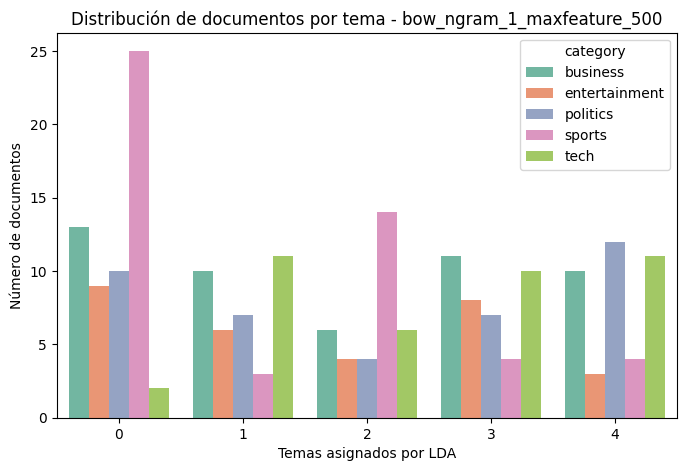

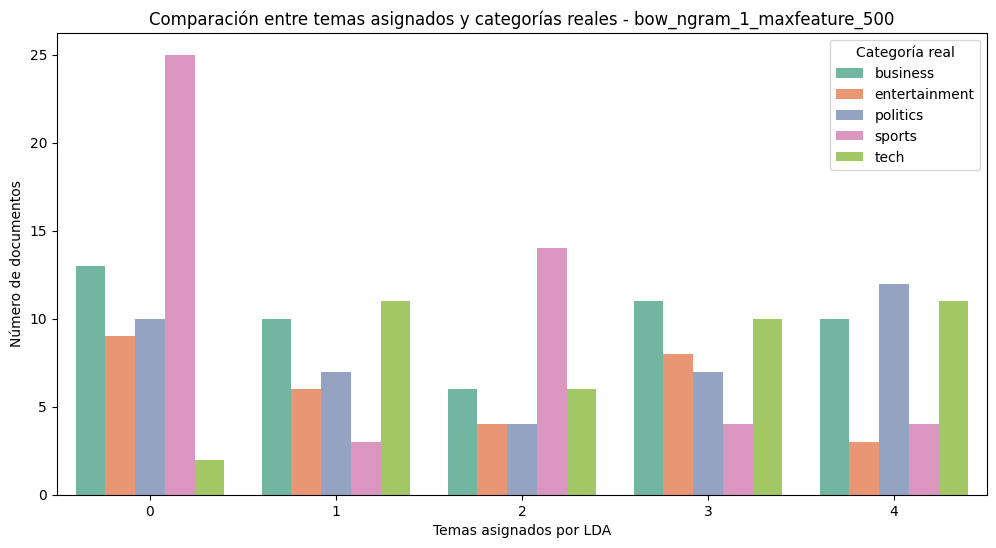

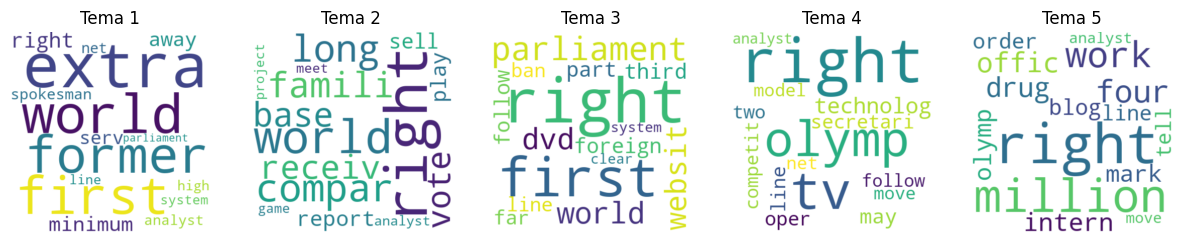



Graphics bow_ngram_2_maxfeature_500




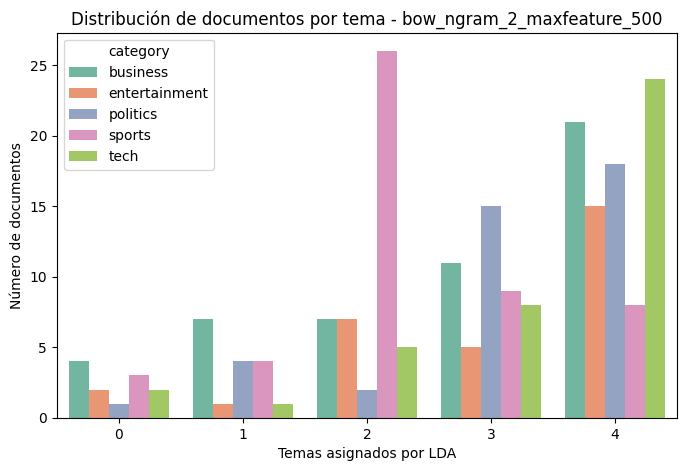

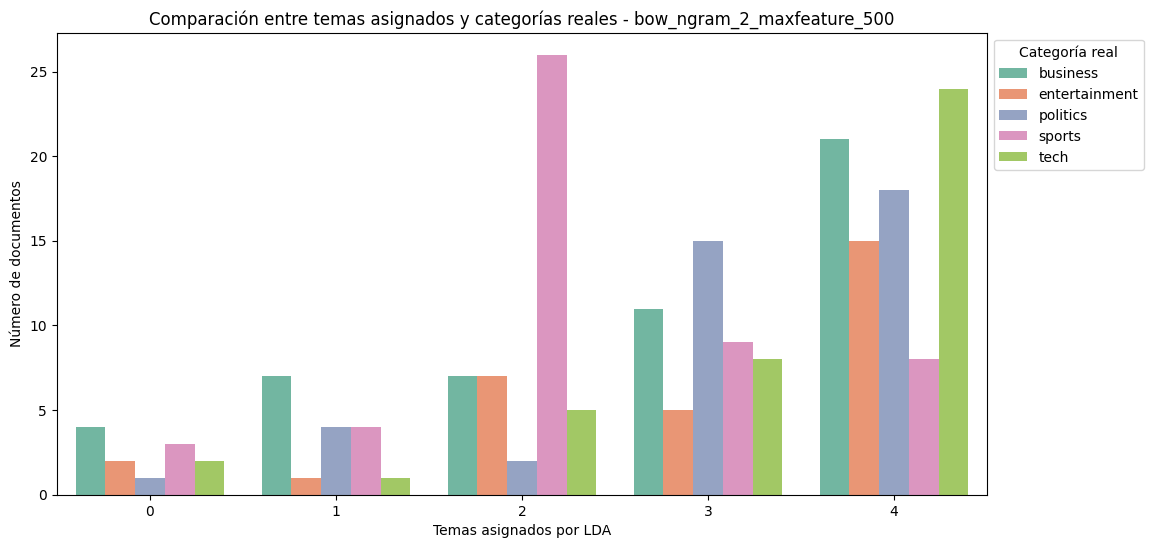

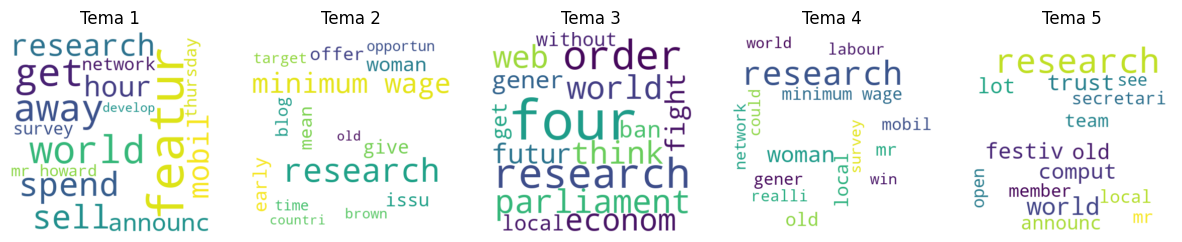



Graphics bow_ngram_3_maxfeature_500




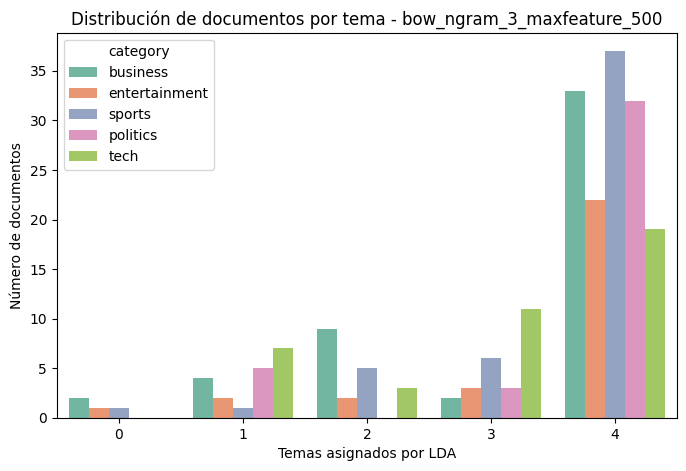

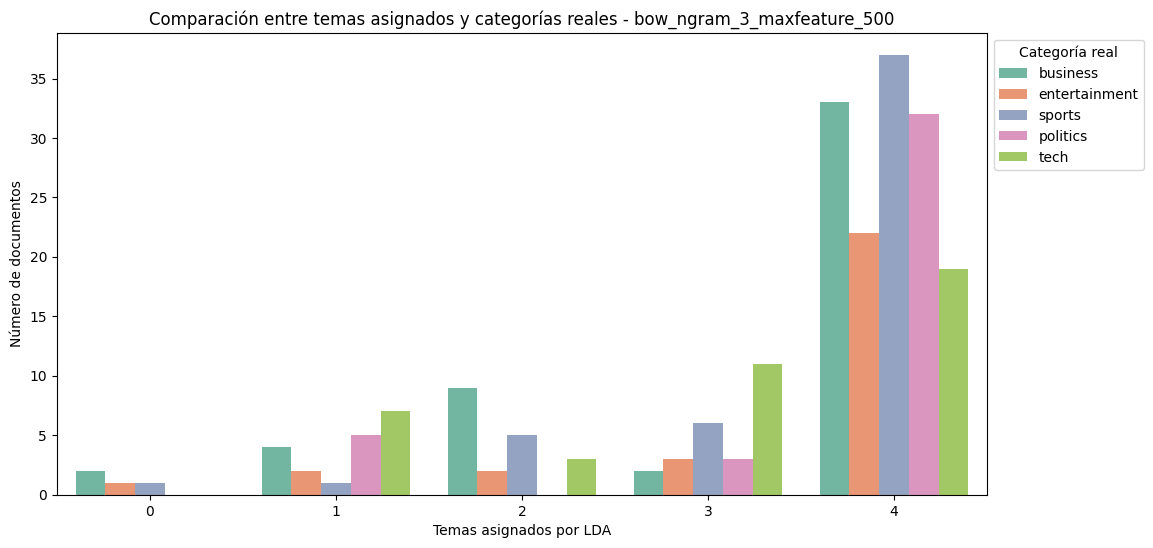

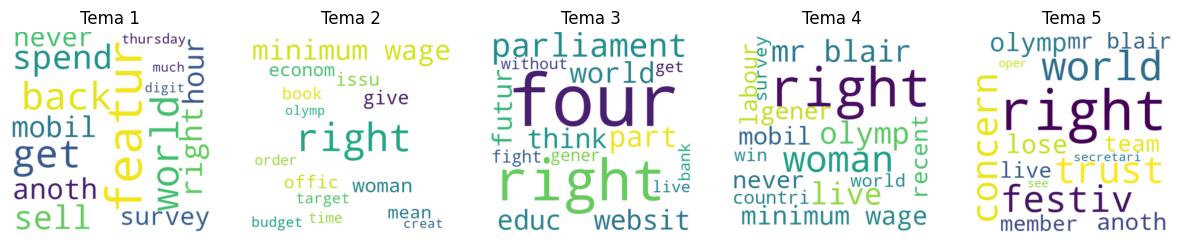



Graphics bow_ngram_1_maxfeature_1000




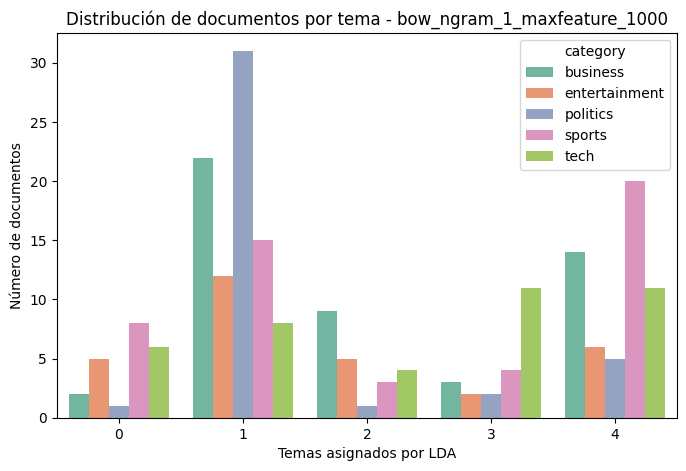

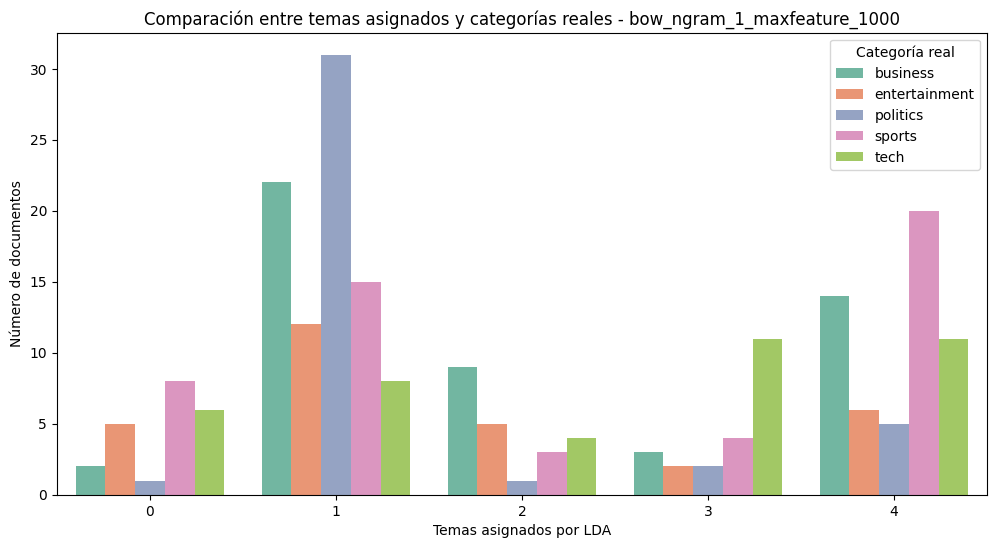

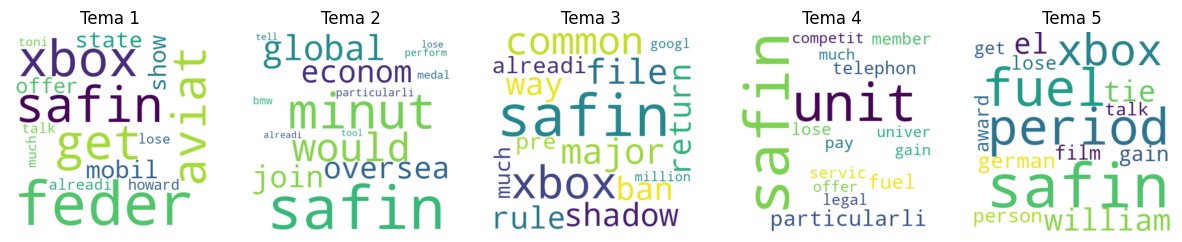



Graphics bow_ngram_2_maxfeature_1000




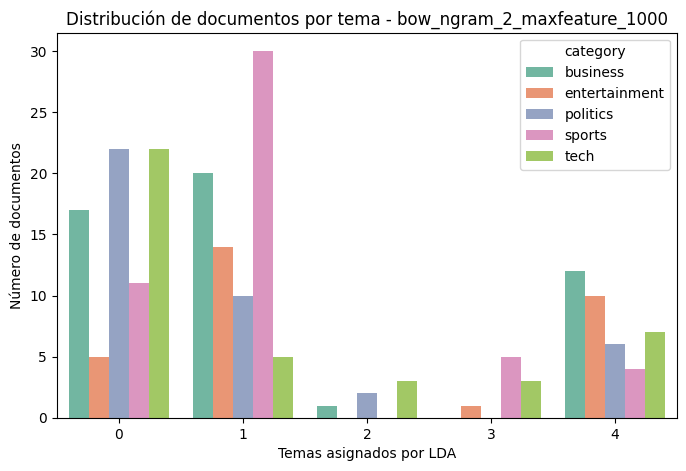

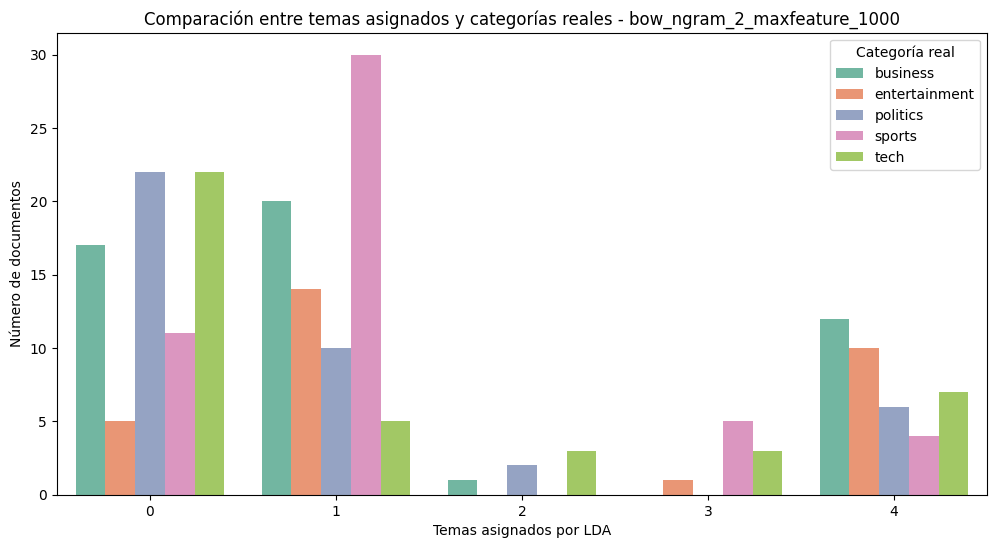

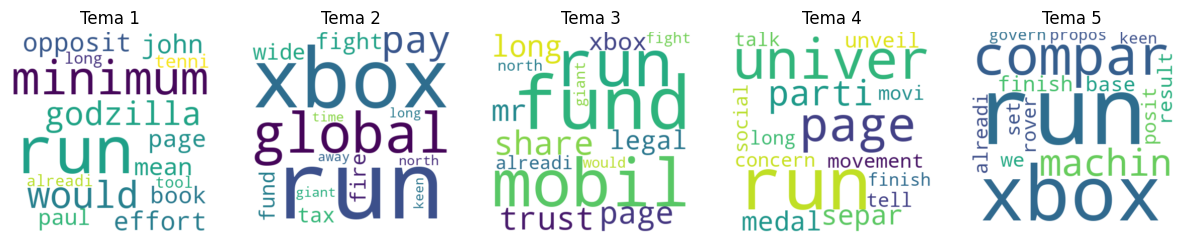



Graphics bow_ngram_3_maxfeature_1000




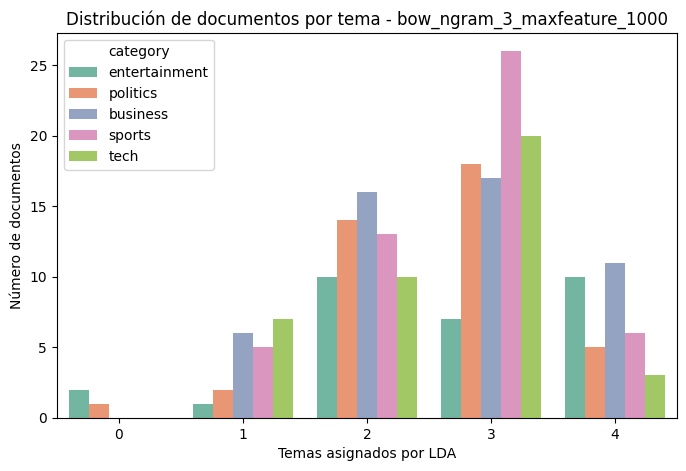

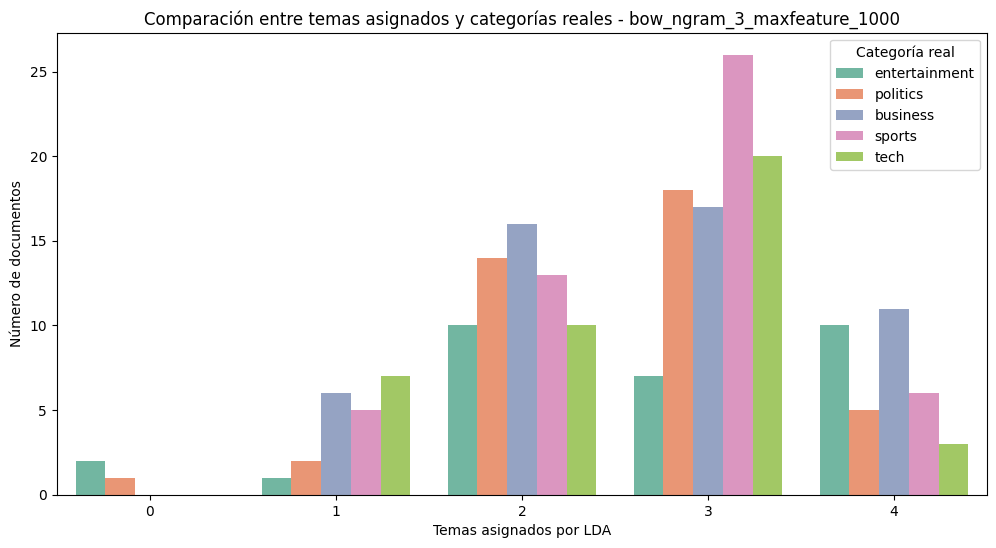

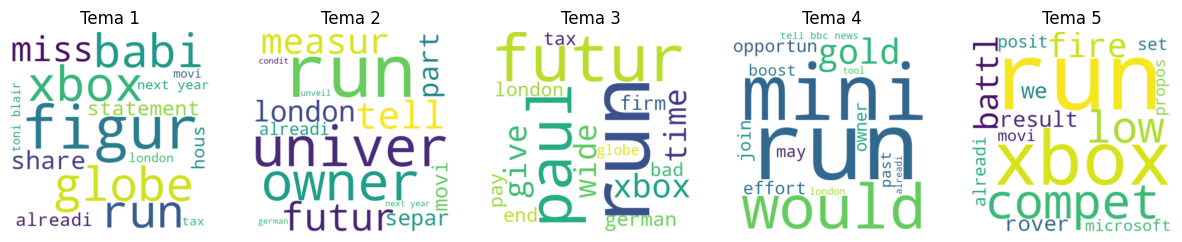



Graphics bow_ngram_1_maxfeature_1500




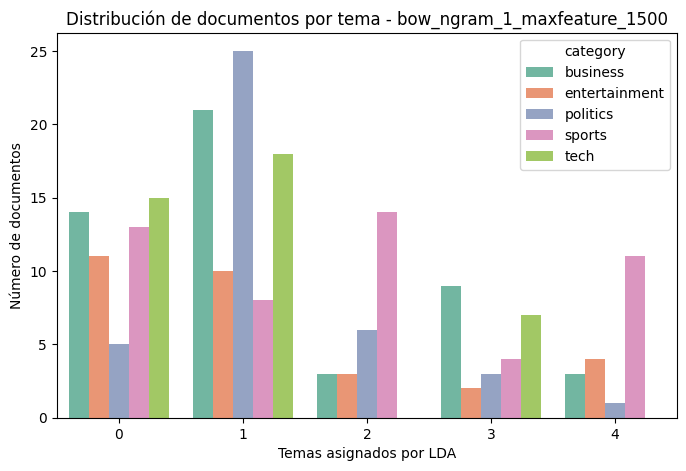

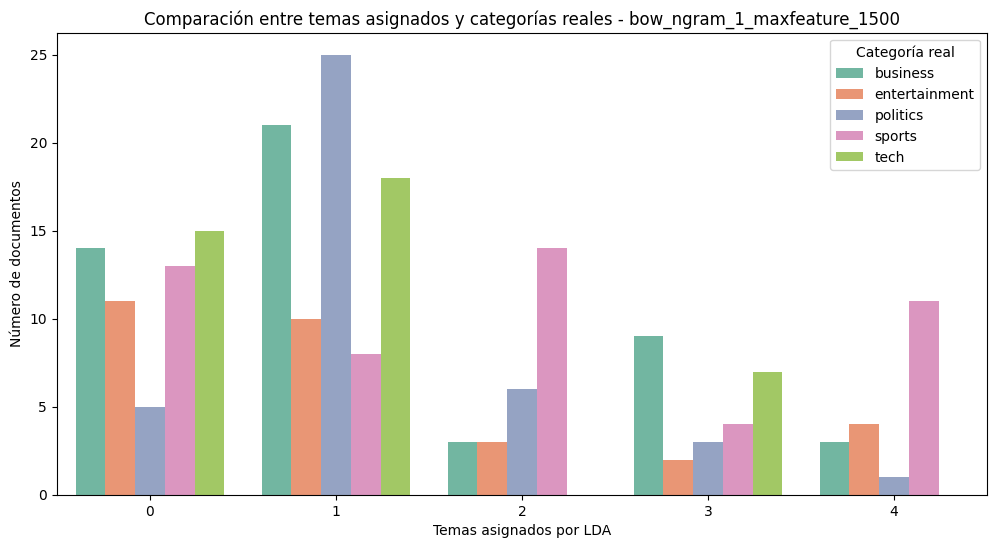

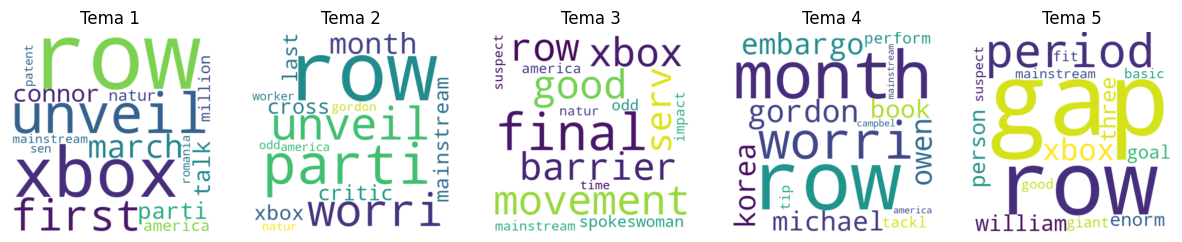



Graphics bow_ngram_2_maxfeature_1500




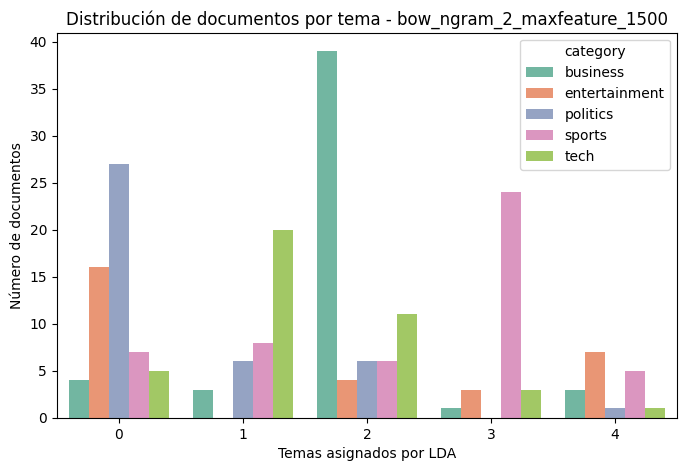

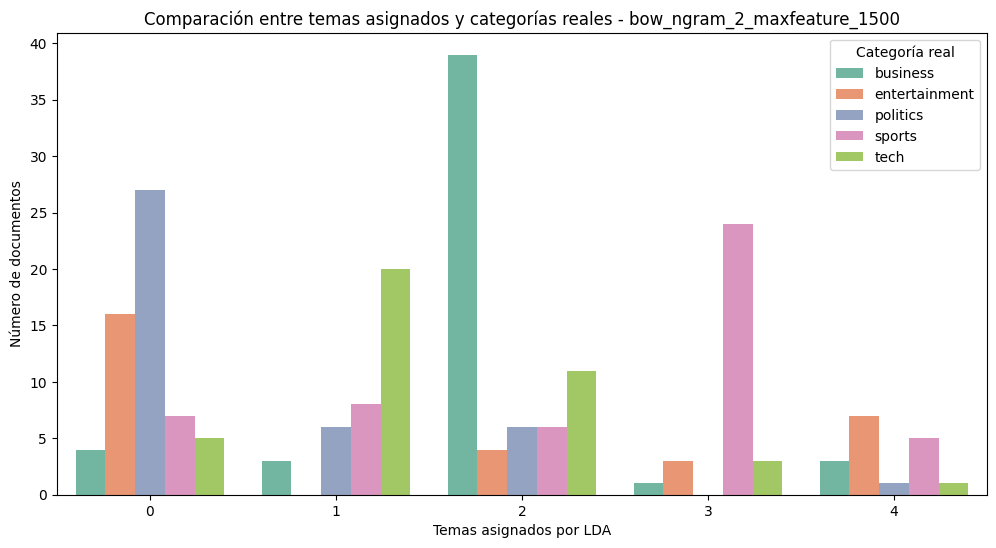

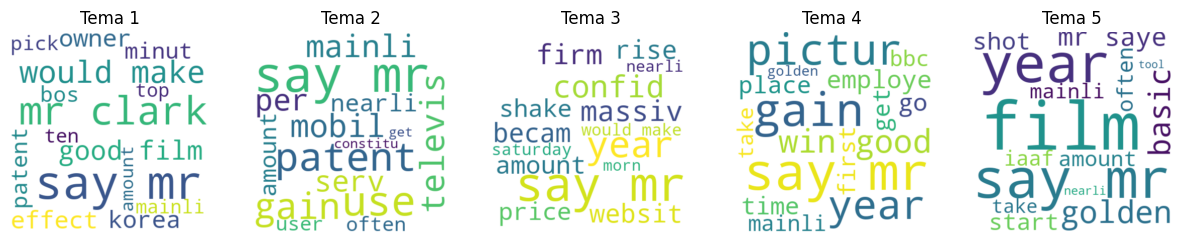



Graphics bow_ngram_3_maxfeature_1500




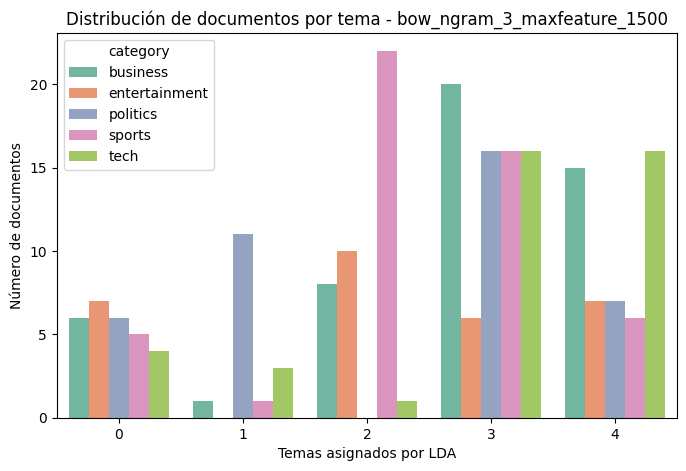

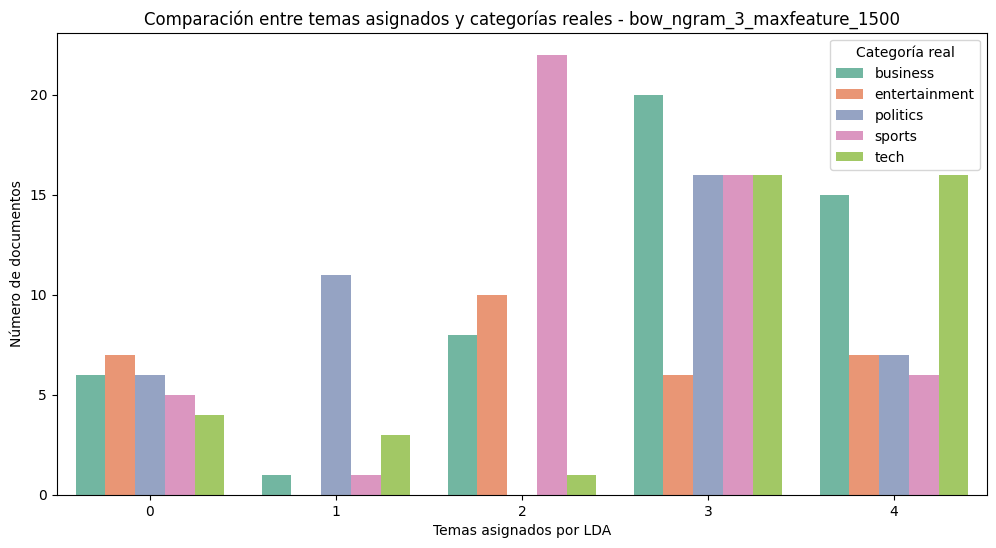

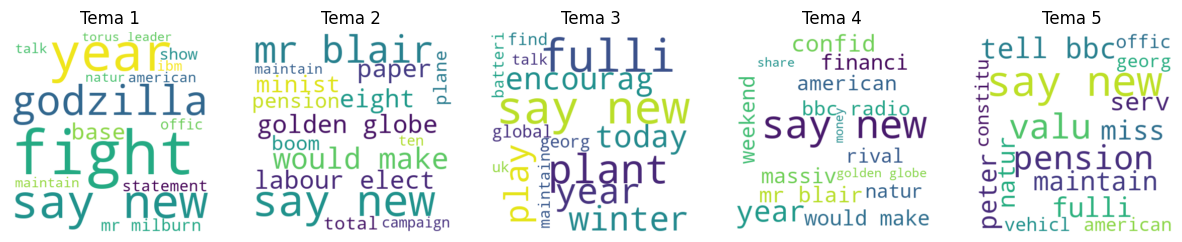



Graphics bow_ngram_1_maxfeature_2000




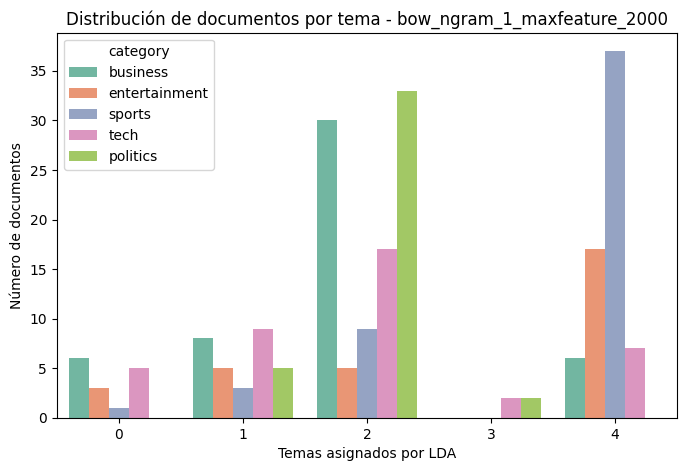

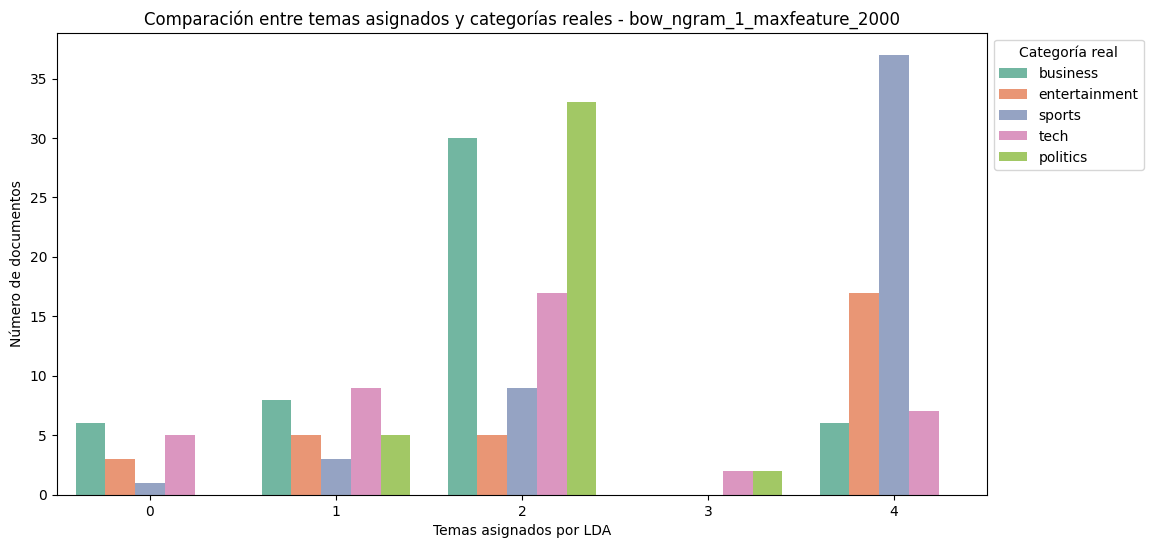

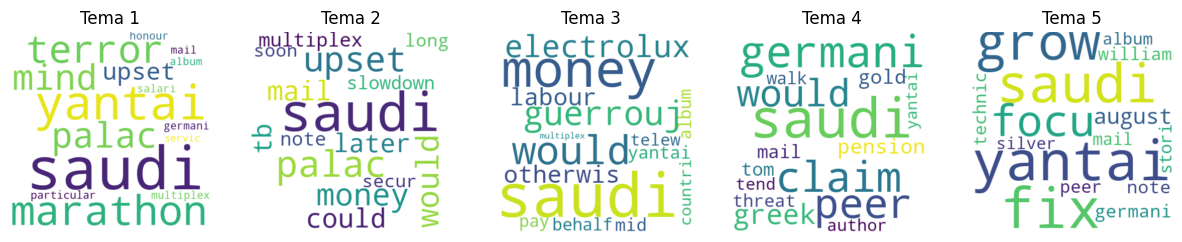



Graphics bow_ngram_2_maxfeature_2000




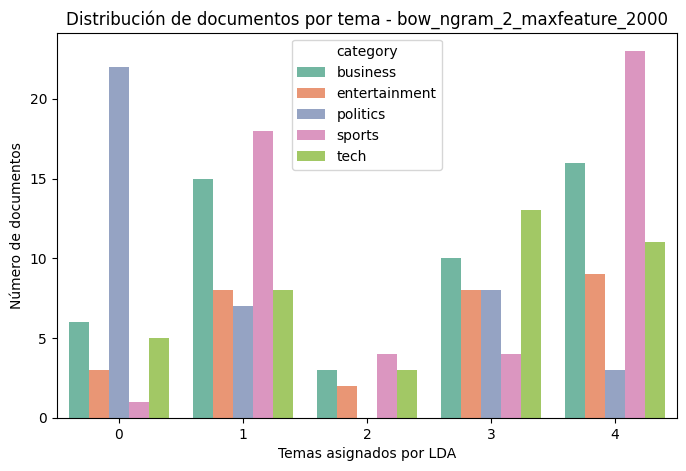

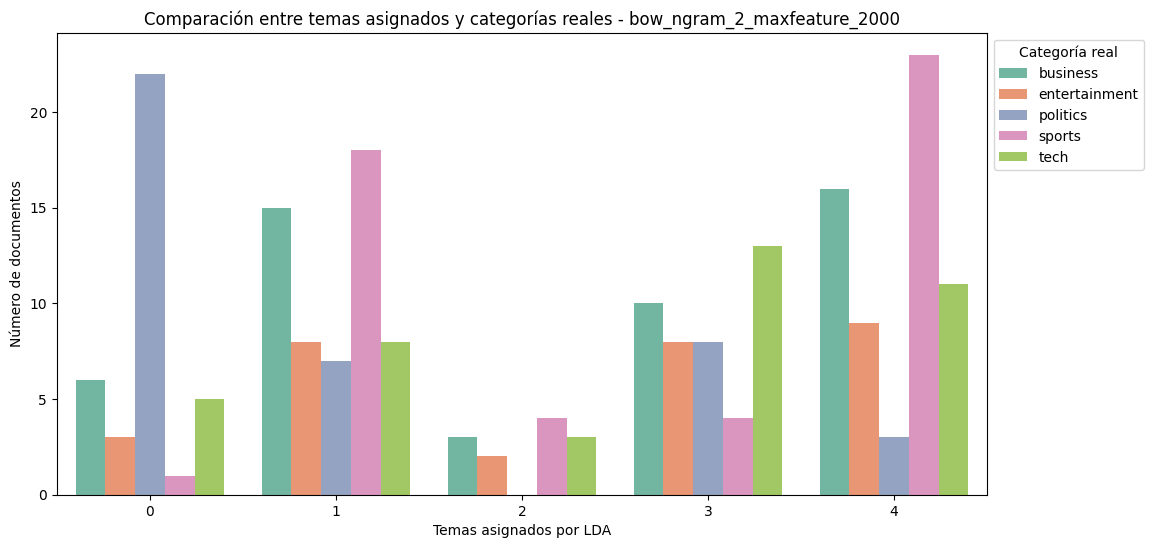

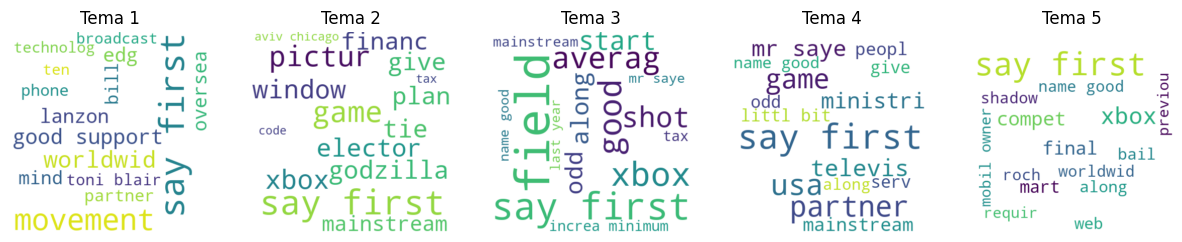



Graphics bow_ngram_3_maxfeature_2000




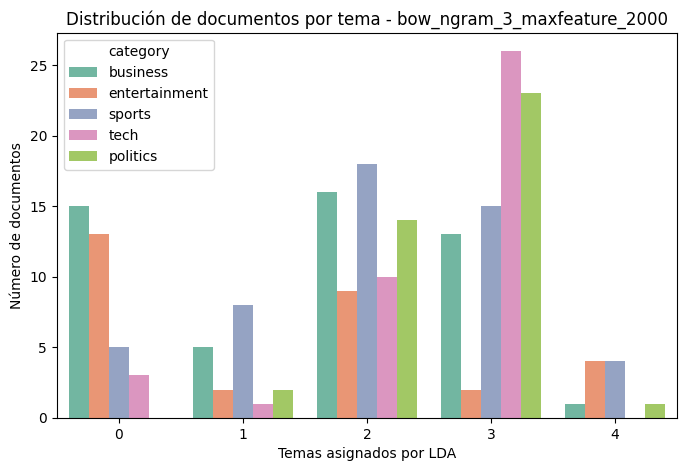

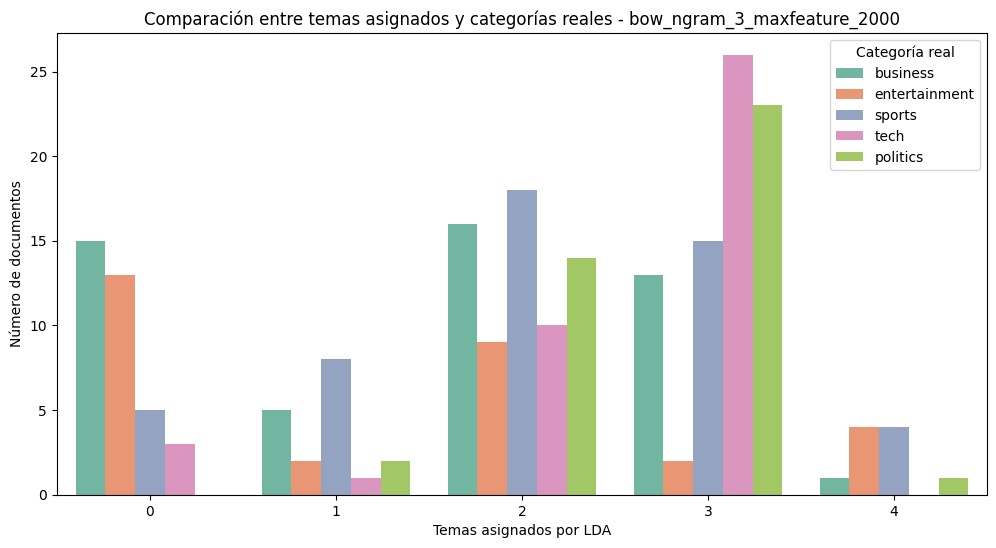

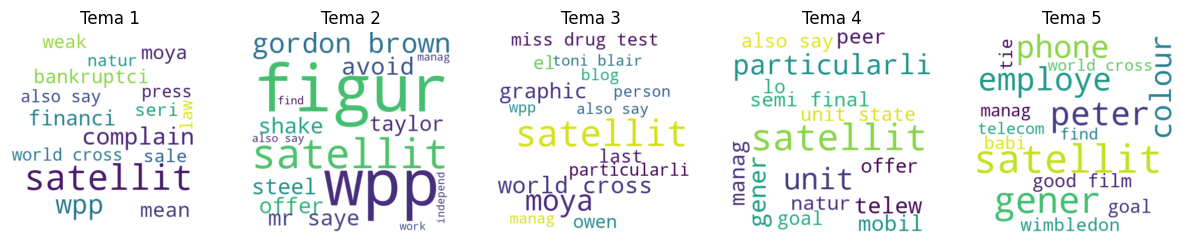



Graphics tfidf_ngram_1_maxfeature_500




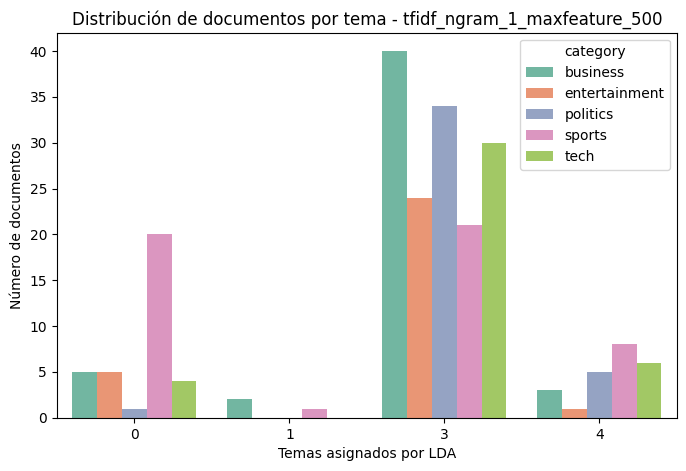

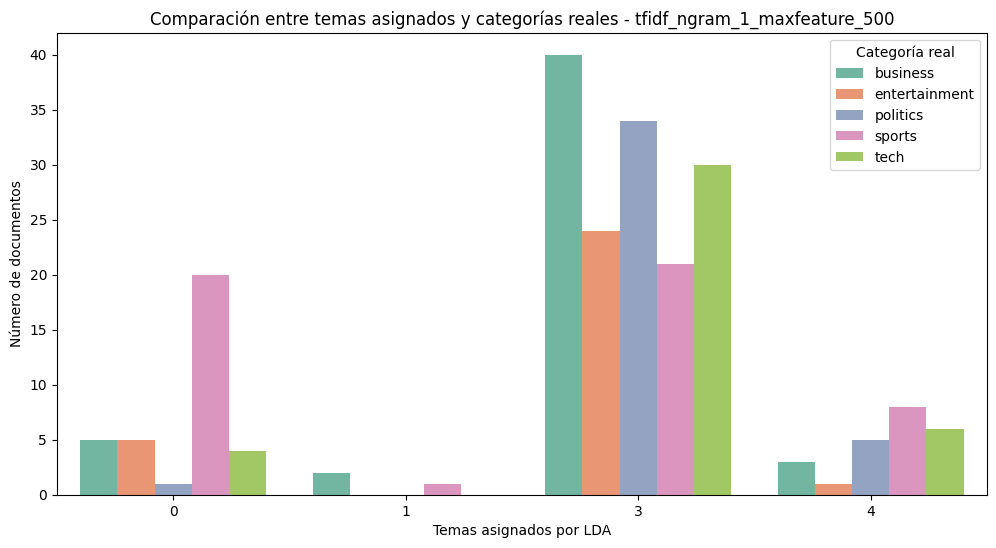

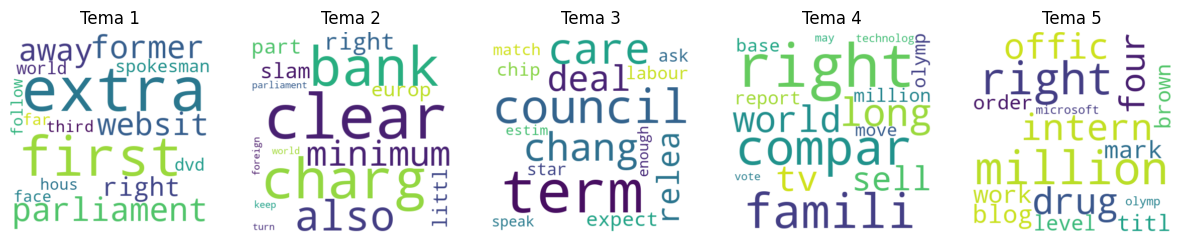



Graphics tfidf_ngram_2_maxfeature_500




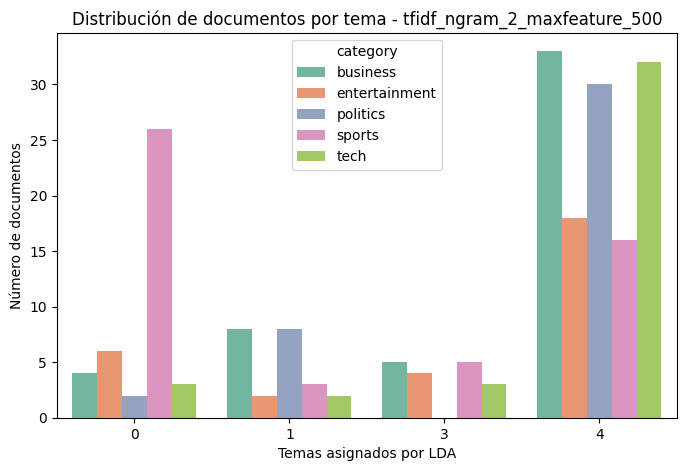

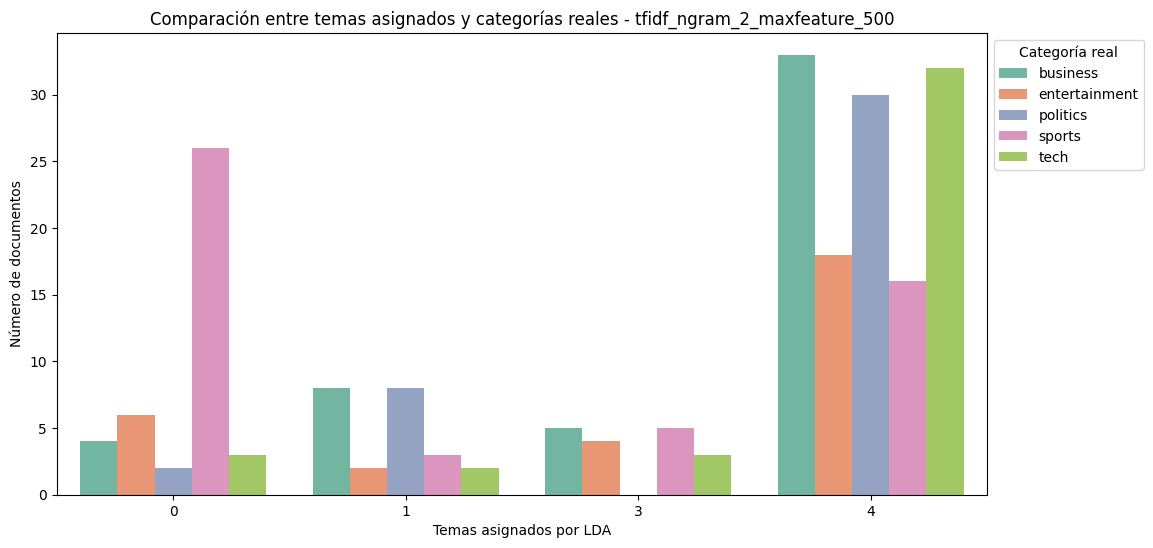

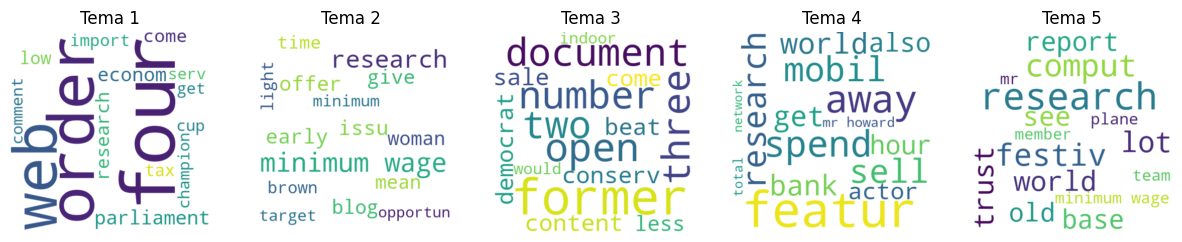



Graphics tfidf_ngram_3_maxfeature_500




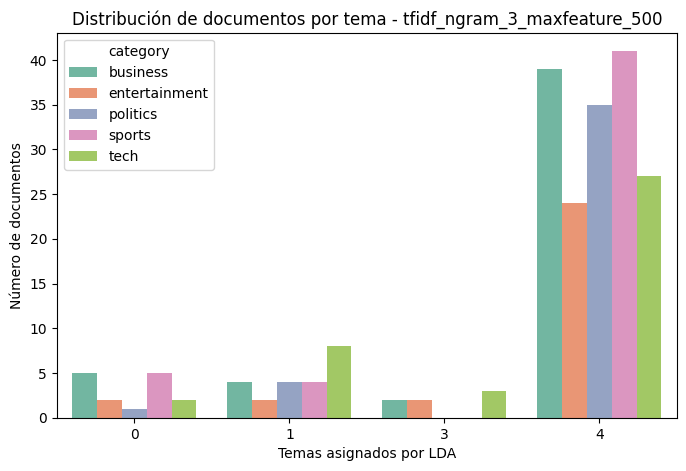

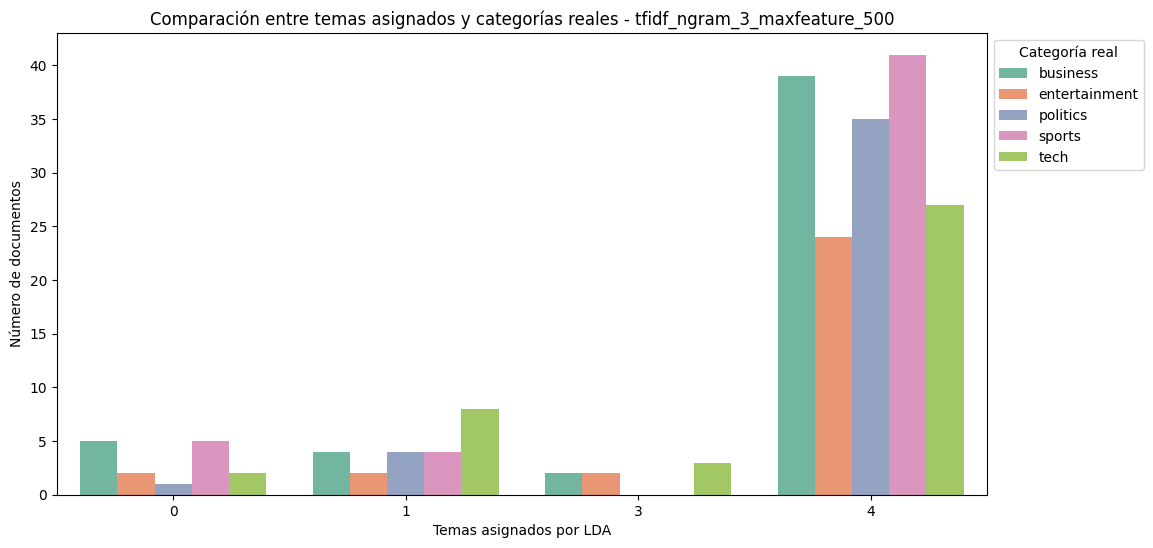

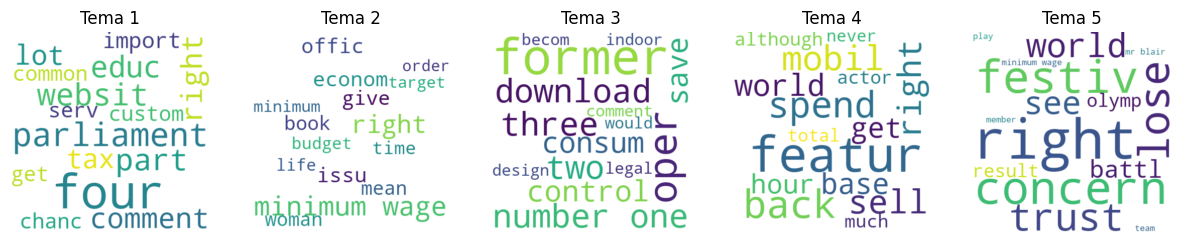



Graphics tfidf_ngram_1_maxfeature_1000




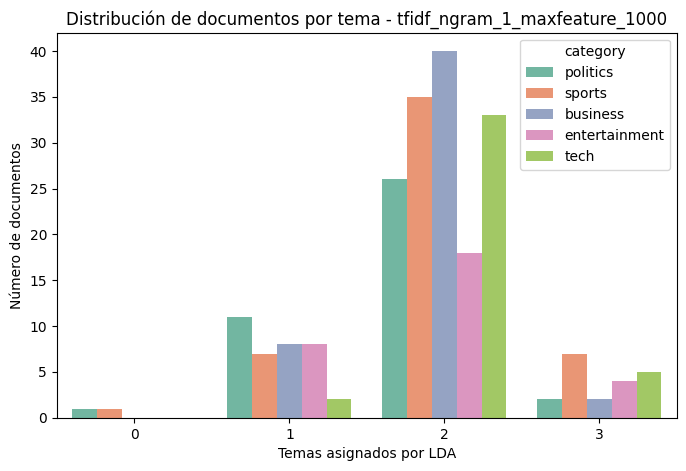

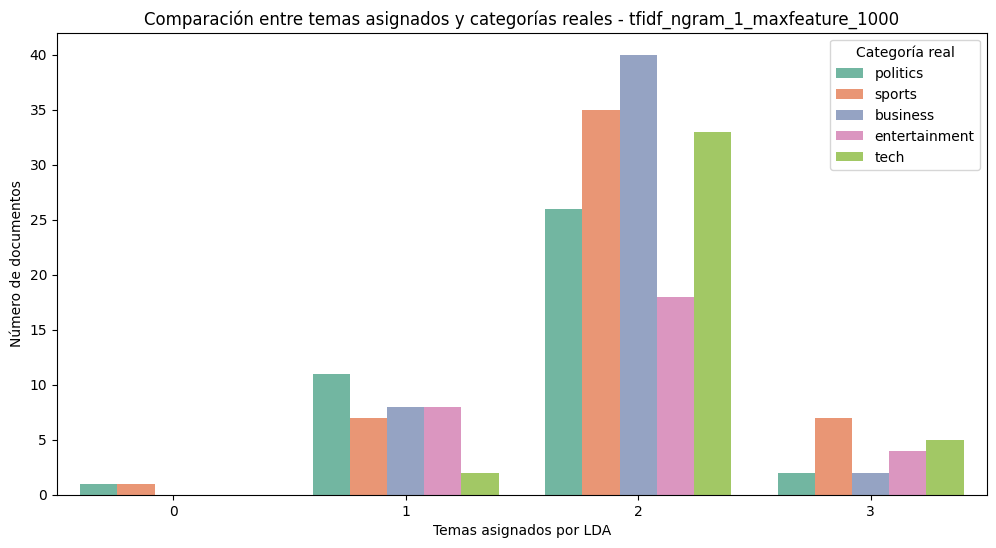

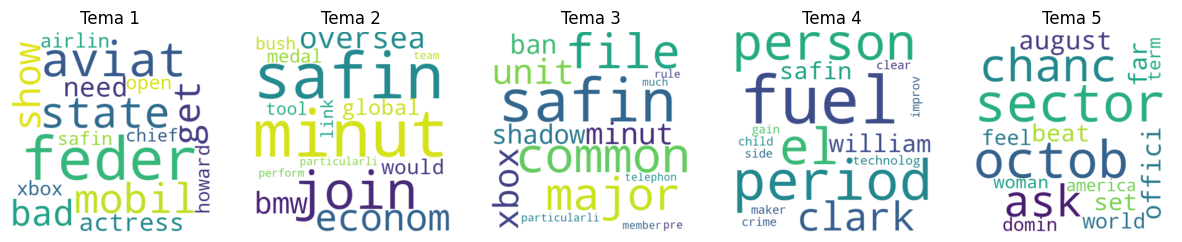



Graphics tfidf_ngram_2_maxfeature_1000




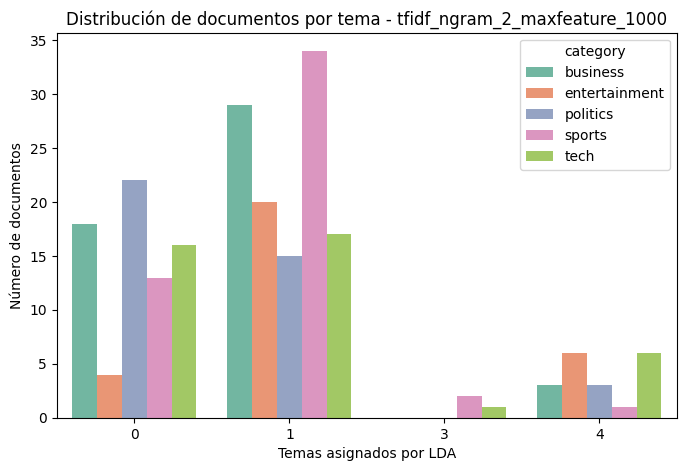

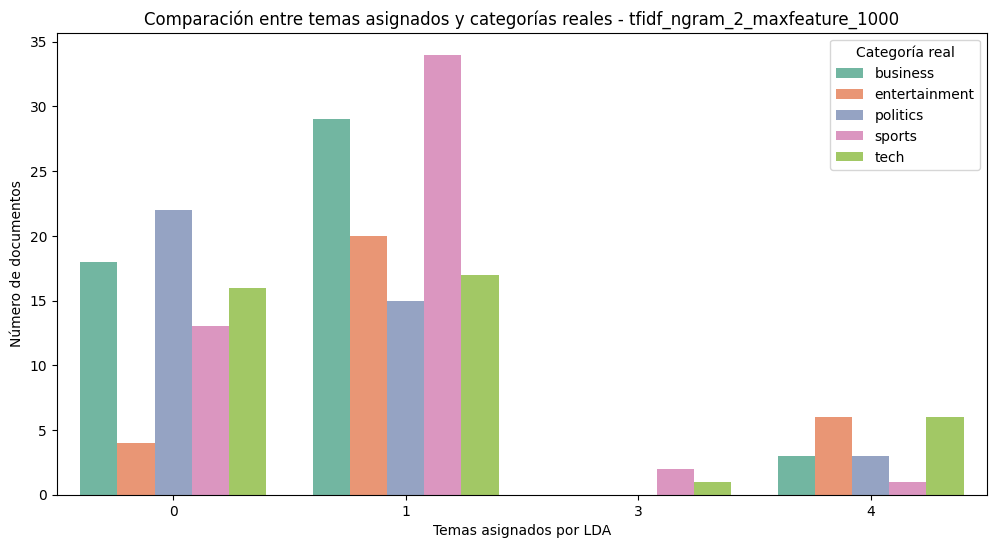

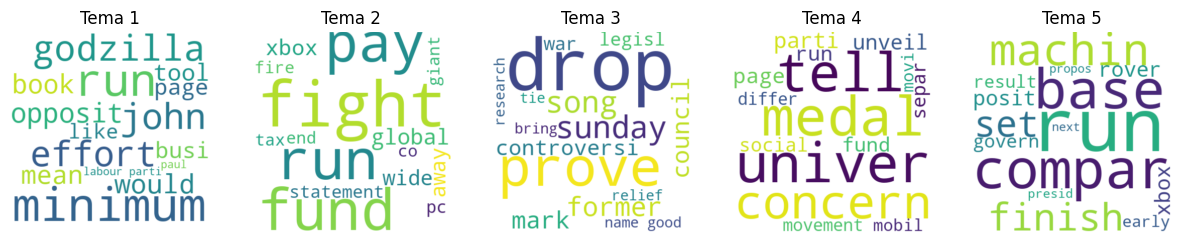



Graphics tfidf_ngram_3_maxfeature_1000




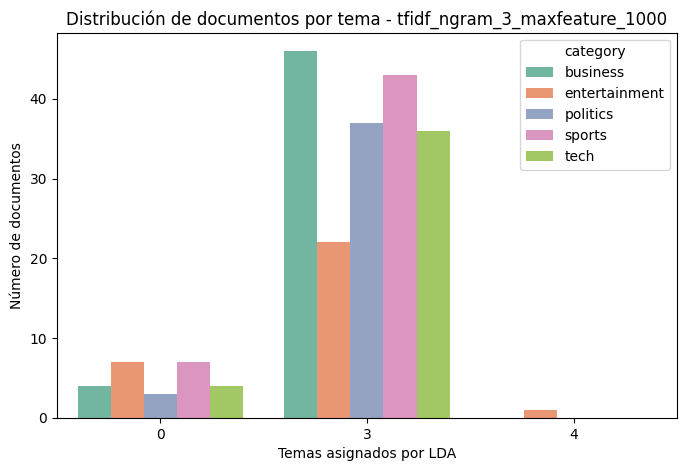

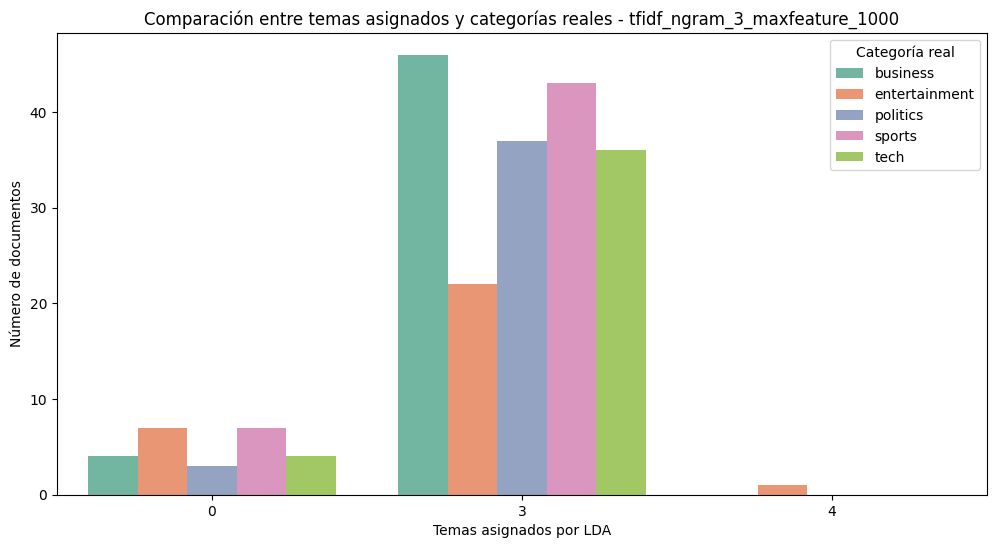

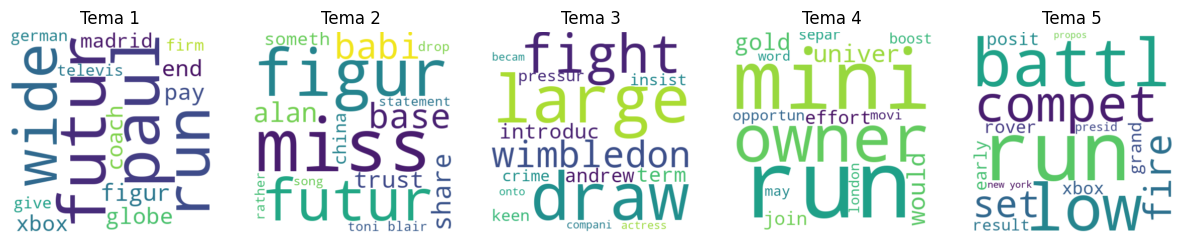



Graphics tfidf_ngram_1_maxfeature_1500




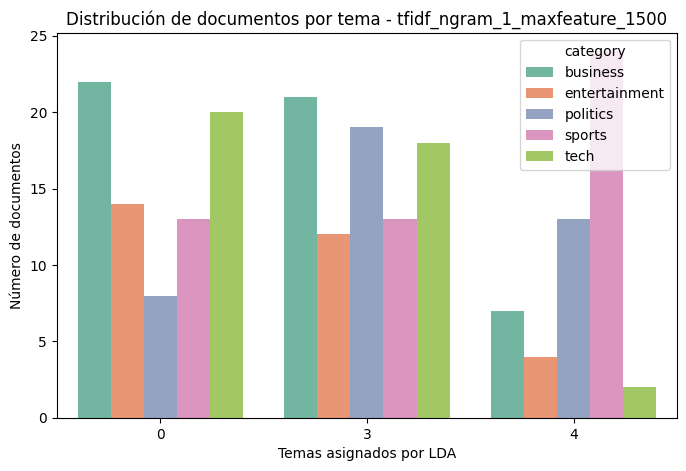

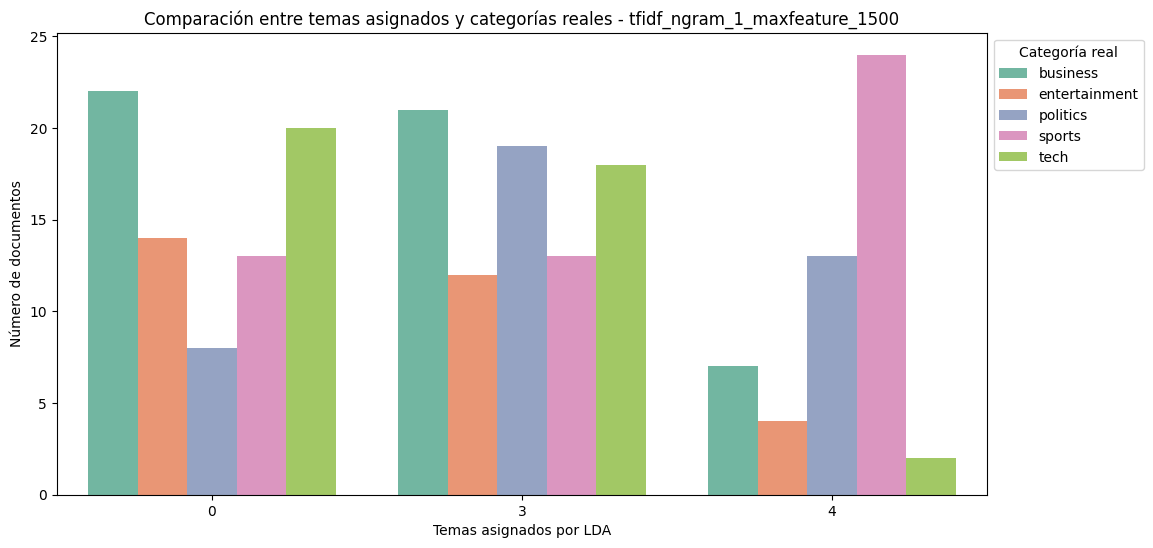

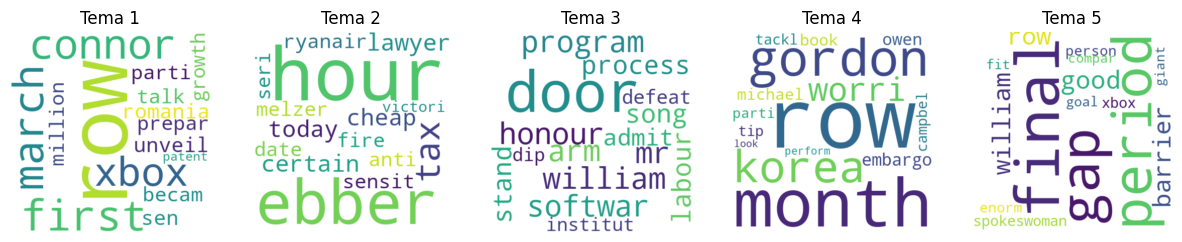



Graphics tfidf_ngram_2_maxfeature_1500




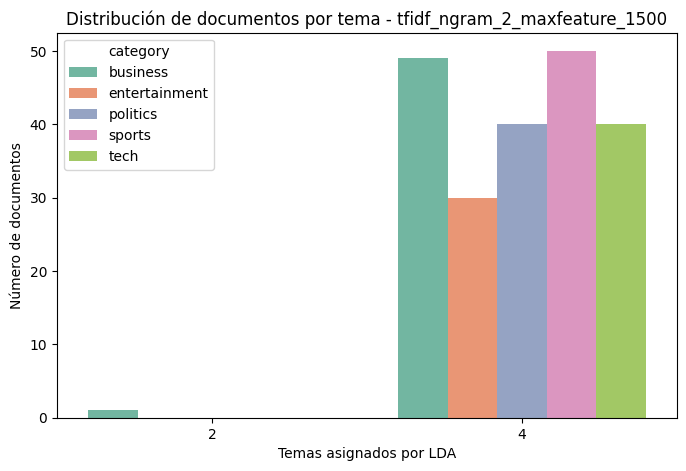

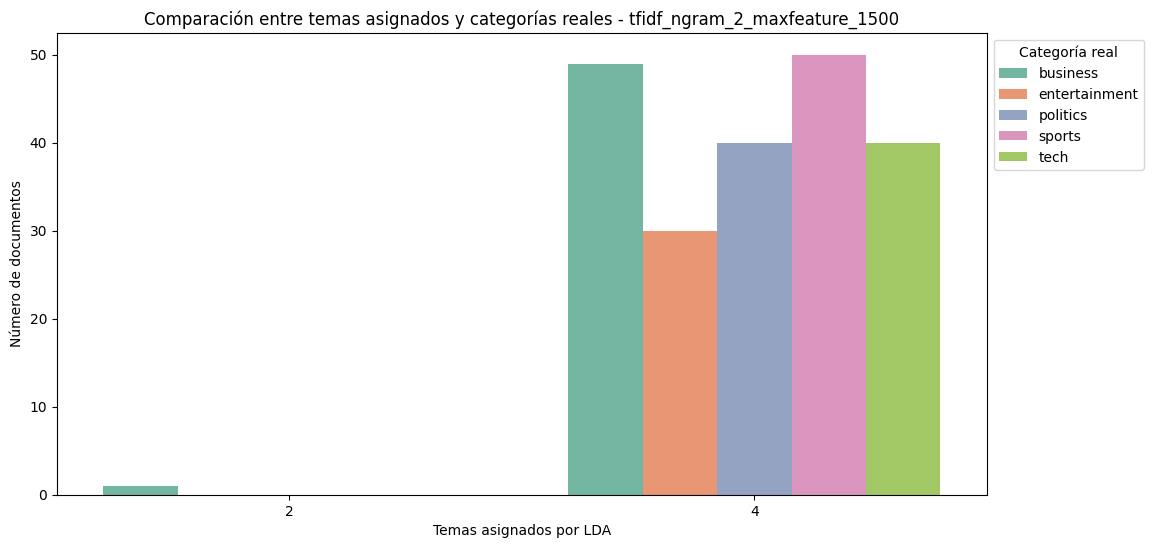

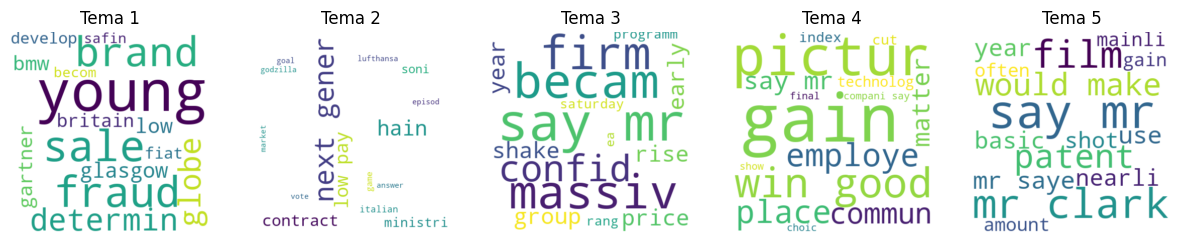



Graphics tfidf_ngram_3_maxfeature_1500




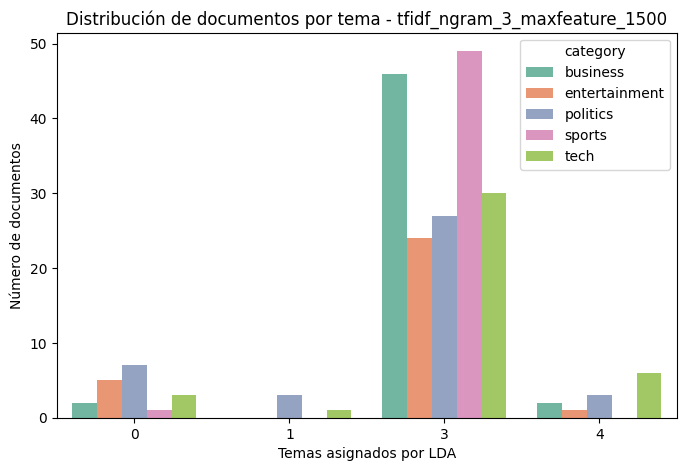

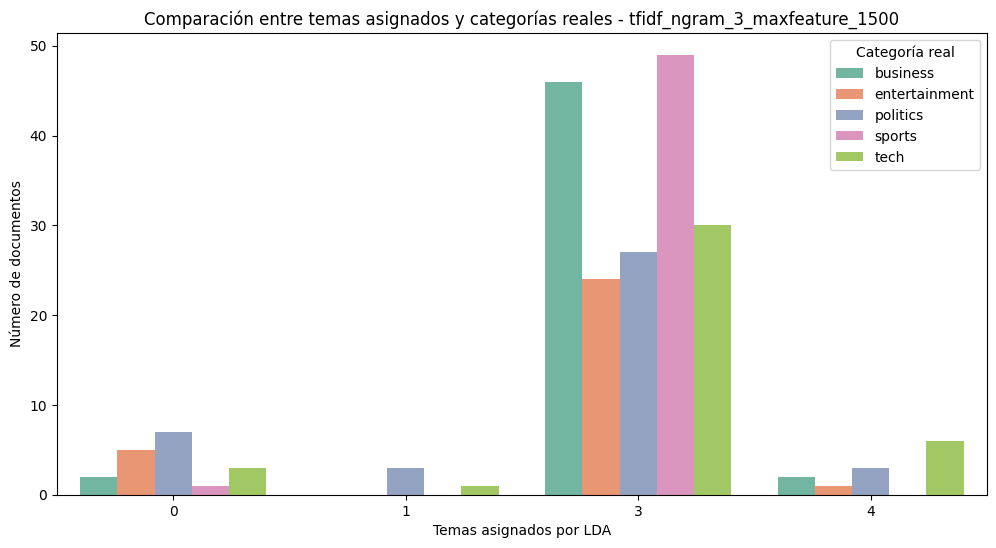

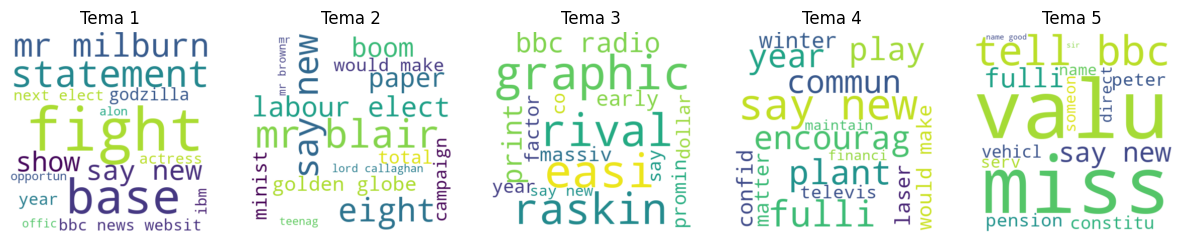



Graphics tfidf_ngram_1_maxfeature_2000




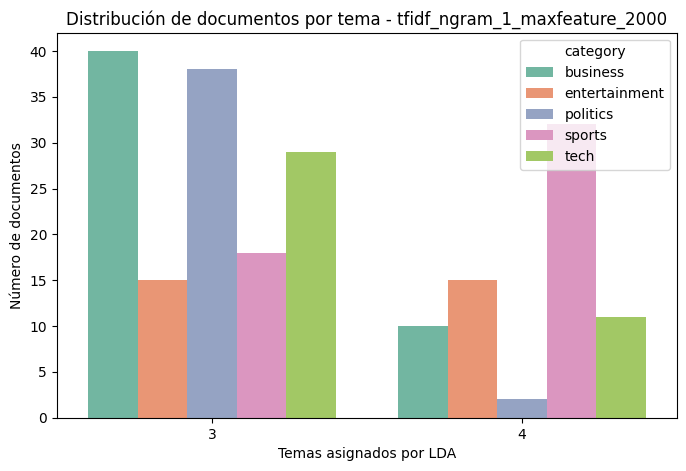

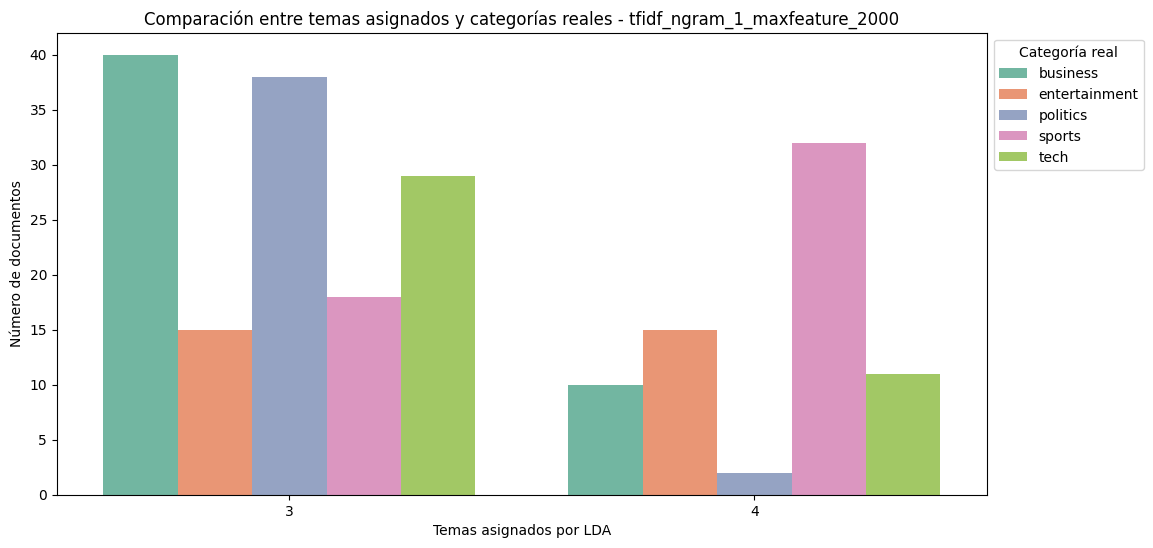

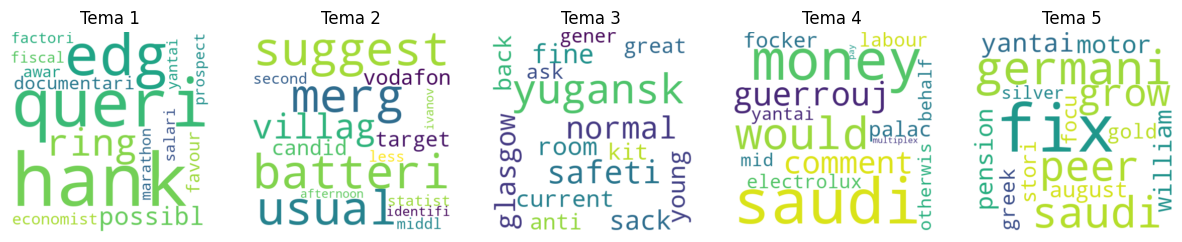



Graphics tfidf_ngram_2_maxfeature_2000




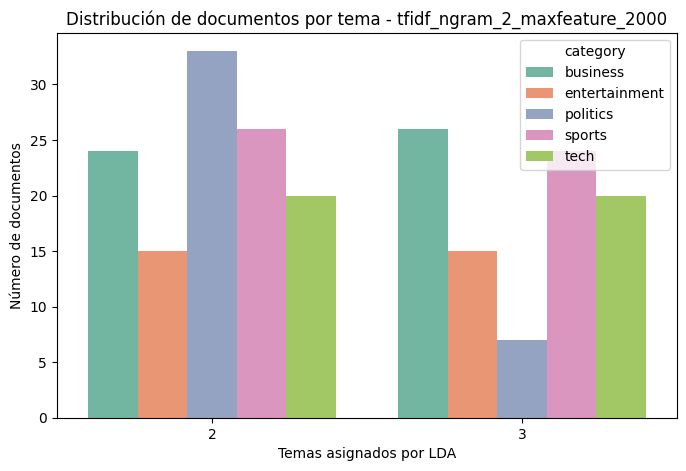

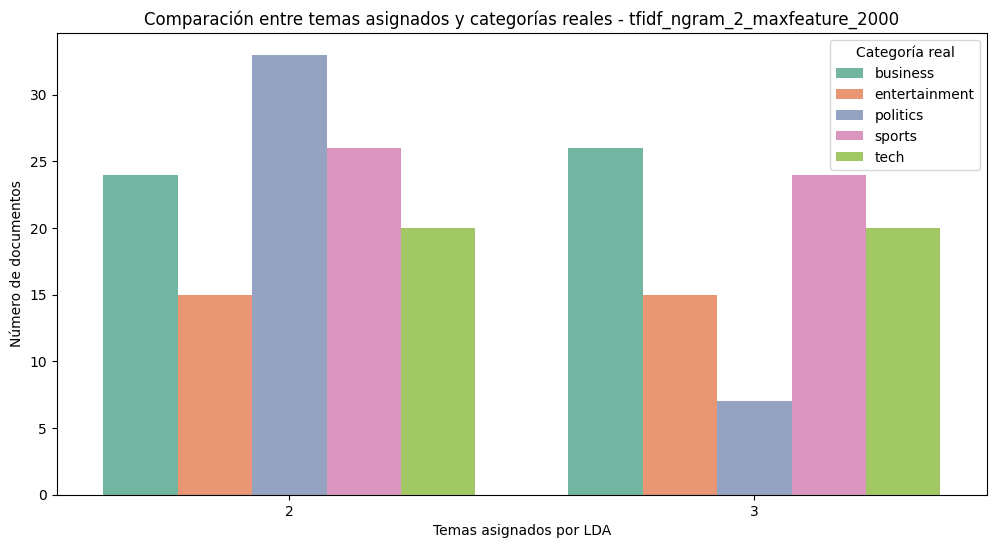

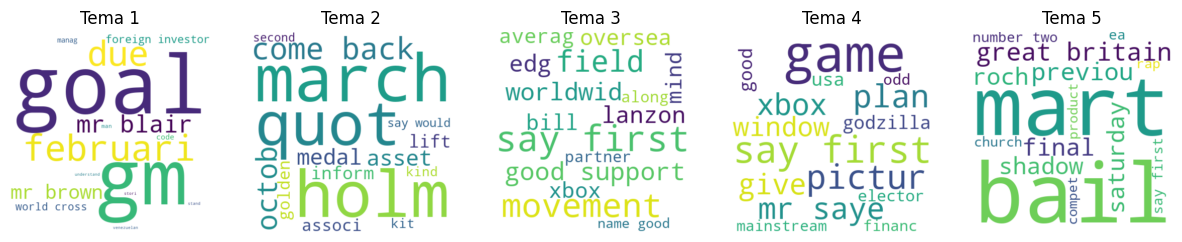



Graphics tfidf_ngram_3_maxfeature_2000




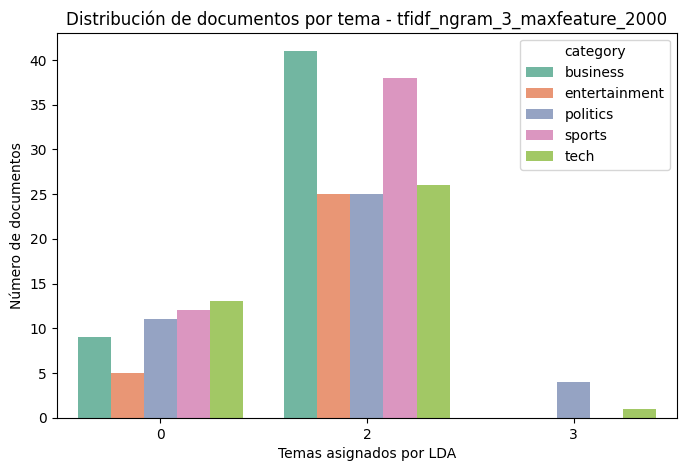

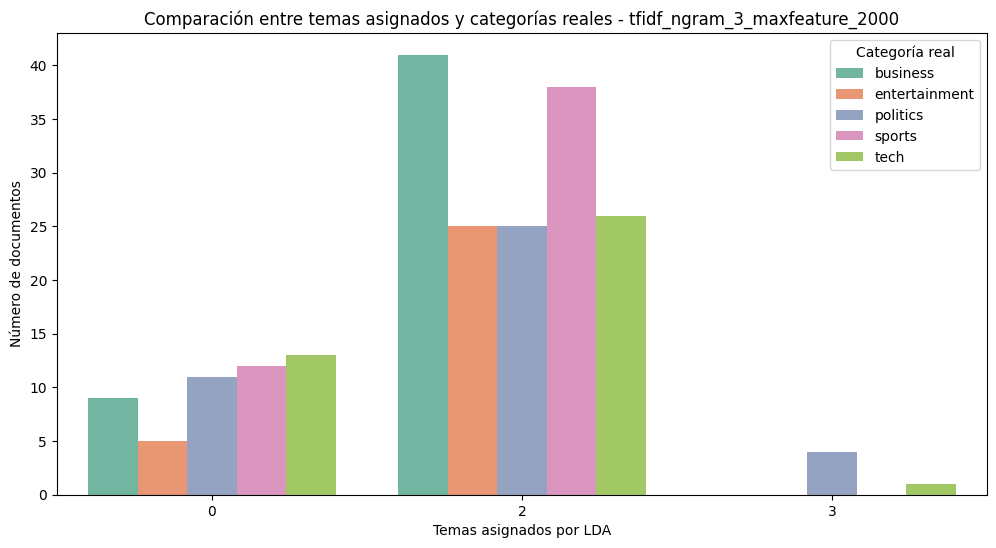

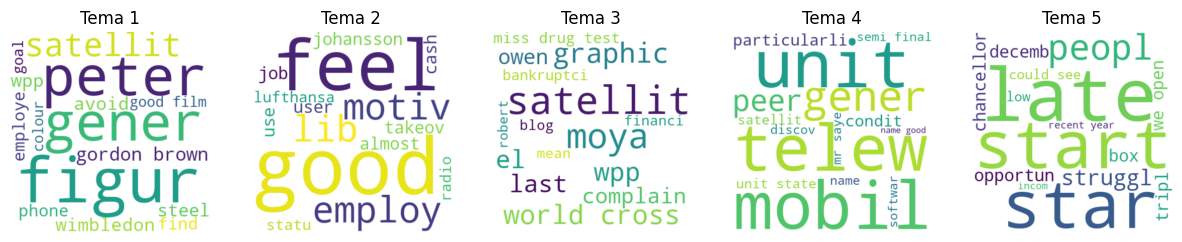

In [47]:
# Evaluación en conjunto de prueba (df_test)
df_test["processed_text"] = df_test["processed"].apply(lambda x: " ".join(x))  # Unimos tokens en texto

for rep in representations:
  for max_feature in max_features:
    for ngram_range in n_gram_ranges:
      key = f"{rep}_ngram_{ngram_range[1]}_maxfeature_{max_feature}"
      vectorizer, _ = represent_text(df_test, method=rep, ngram_range=ngram_range, max_features=max_feature)
      X_test = vectorizer.transform(df_test["processed_text"])  # Usamos el vectorizador entrenado
      doc_topic_distributions_test = models[key]["model"].transform(X_test)
      df_test["assigned_topic"] = np.argmax(doc_topic_distributions_test, axis=1)
      print(f'\n==================\n\nGraphics {key}\n\n==================\n')
      plot_topic_distribution(df_test, key)
      plot_category_vs_topic(df_test, key)

      # Promediar la distribución de tópicos para todo el conjunto de prueba
      feature_names = vectorizer.get_feature_names_out()
      topic_weights = np.mean(doc_topic_distributions_test, axis=0)

      plot_wordclouds(models[key]["model"], feature_names, num_topics=5)

In [48]:
with open("models/lda_models.pkl", "wb") as f:
    pickle.dump(models, f)

# 7. Almacenamiento de Datos

En esta sección se guardan los DataFrames finales de entrenamiento y prueba en archivos CSV.  
Estos archivos permiten tener una copia persistente del dataset ya preprocesado y etiquetado, lo cual es útil para futuras referencias, análisis o para compartir el dataset sin tener que ejecutar nuevamente todo el pipeline de preprocesamiento.

In [ ]:
# Guardar el conjunto de entrenamiento y de prueba en archivos CSV
df_train.to_csv('csv_files/results/training_dataset.csv')
df_test.to_csv('csv_files/results/testing_dataset.csv')